## MLP: Initializations

In [1]:
## MLP: Initializations# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# https://github.com/wagonhelm/NaNmnist/blob/master/NaNmnist.ipynb
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [0]:
# Network Parameters
n_hidden_1 = 501 # 1st layer number of neurons
n_hidden_2 = 101 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [0]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [0]:
# Weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+501)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.058, mean=0)), #512x128 # sqrt(2/(501+101)) = 0.058
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.134, mean=0))  #101x10
}


# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.063, mean=0)),    #784x501
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.140, mean=0)), #501x101
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.134, mean=0))  #101x10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #501x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #101x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

In [0]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

<h3> Model 1: input (784) - sigmoid(501) - sigmoid(101) - 
softmax(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer with SGD Weight__

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.695818543 test cost=1.689475955
Epoch: 0002 train cost=1.541474789 test cost=1.539817623
Epoch: 0003 train cost=1.517574779 test cost=1.516800298
Epoch: 0004 train cost=1.504511440 test cost=1.505309247
Epoch: 0005 train cost=1.494976205 test cost=1.498124841
Epoch: 0006 train cost=1.489379820 test cost=1.492817287
Epoch: 0007 train cost=1.484008163 test cost=1.489408824
Epoch: 0008 train cost=1.481385316 test cost=1.486635379
Epoch: 0009 train cost=1.477923827 test cost=1.484846907
Epoch: 0010 train cost=1.475228988 test cost=1.483537768
Epoch: 0011 train cost=1.473722297 test cost=1.482456403
Epoch: 0012 train cost=1.471928724 test cost=1.481792023
Epoch: 0013 train cost=1.470463281 test cost=1.481456827
Epoch: 0014 train cost=1.469666128 test cost=1.481187803
Epoch: 0015 train cost=1.468609067 test cos

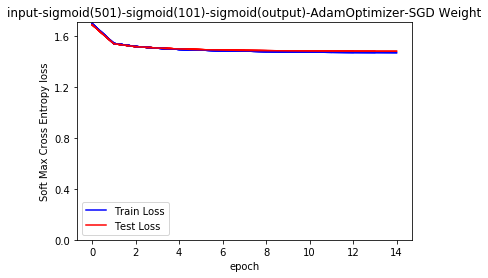

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

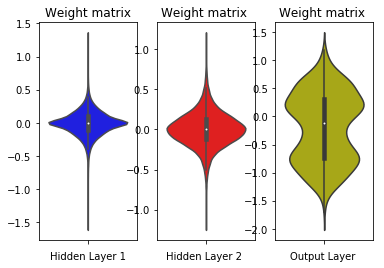

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with SGD Weight__

Epoch: 0001 train cost=2.323585433 test cost=2.325197864
Epoch: 0002 train cost=2.320215197 test cost=2.321344132
Epoch: 0003 train cost=2.316451461 test cost=2.317630173
Epoch: 0004 train cost=2.312757143 test cost=2.314182770
Epoch: 0005 train cost=2.309774633 test cost=2.311090720
Epoch: 0006 train cost=2.307785230 test cost=2.308357812
Epoch: 0007 train cost=2.305439533 test cost=2.306016606
Epoch: 0008 train cost=2.303272062 test cost=2.304112383
Epoch: 0009 train cost=2.302319225 test cost=2.302565997
Epoch: 0010 train cost=2.300994676 test cost=2.301266152
Epoch: 0011 train cost=2.299902275 test cost=2.300168152
Epoch: 0012 train cost=2.299021292 test cost=2.299299704
Epoch: 0013 train cost=2.298337829 test cost=2.298556362
Epoch: 0014 train cost=2.297741084 test cost=2.297877880
Epoch: 0015 train cost=2.297438992 test cost=2.297323148
Accuracy: 0.1135


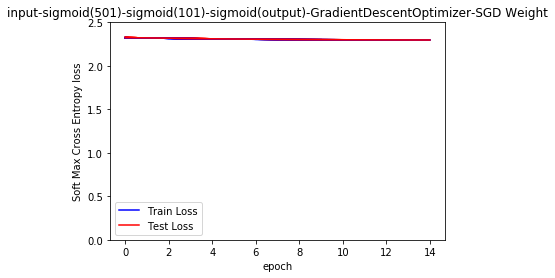

In [0]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer- SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

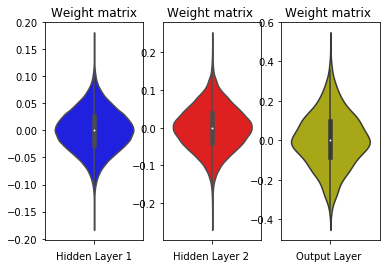

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + AdamOptimizer with Relu Weight__

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.678208552 test cost=1.672103669
Epoch: 0002 train cost=1.541016988 test cost=1.538911870
Epoch: 0003 train cost=1.516144870 test cost=1.516935135
Epoch: 0004 train cost=1.503912258 test cost=1.505415742
Epoch: 0005 train cost=1.494792344 test cost=1.497865611
Epoch: 0006 train cost=1.488523316 test cost=1.492803824
Epoch: 0007 train cost=1.484137435 test cost=1.488975068
Epoch: 0008 train cost=1.480479831 test cost=1.486530253
Epoch: 0009 train cost=1.477273307 test cost=1.485001892
Epoch: 0010 train cost=1.474831794 test cost=1.483521636
Epoch: 0011 train cost=1.473626275 test cost=1.482744381
Epoch: 0012 train cost=1.471300566 test cost=1.481859865
Epoch: 0013 train cost=1.470069112 test cost=1.481595924
Epoch: 0014 train cost=1.469255777 test cost=1.481075248
Epoch: 0015 train cost=1.468135894 test cos

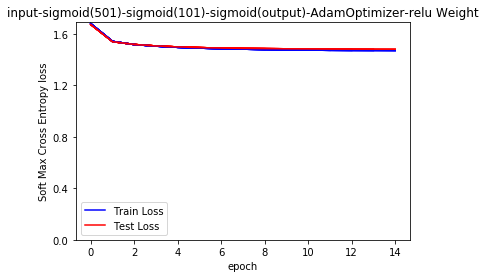

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_relu = multilayer_perceptron(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_relu, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

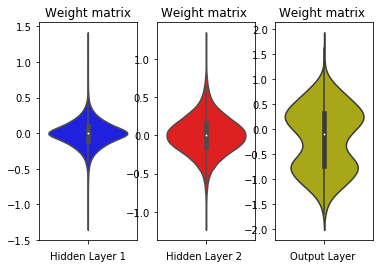

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with relu Weight__

Epoch: 0001 train cost=2.321425910 test cost=2.321420890
Epoch: 0002 train cost=2.317418167 test cost=2.318101721
Epoch: 0003 train cost=2.314790002 test cost=2.315101268
Epoch: 0004 train cost=2.311863385 test cost=2.312415102
Epoch: 0005 train cost=2.309783895 test cost=2.309904128
Epoch: 0006 train cost=2.307477954 test cost=2.307631435
Epoch: 0007 train cost=2.305144472 test cost=2.305529760
Epoch: 0008 train cost=2.303909683 test cost=2.303541877
Epoch: 0009 train cost=2.302153279 test cost=2.301763013
Epoch: 0010 train cost=2.300317831 test cost=2.300063863
Epoch: 0011 train cost=2.298622492 test cost=2.298511578
Epoch: 0012 train cost=2.297624825 test cost=2.297053169
Epoch: 0013 train cost=2.296022946 test cost=2.295661005
Epoch: 0014 train cost=2.295162618 test cost=2.294315121
Epoch: 0015 train cost=2.293522593 test cost=2.293035734
Accuracy: 0.1135


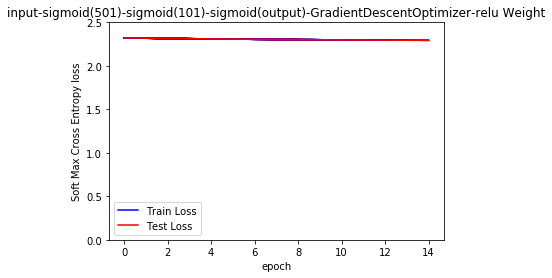

In [0]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer-relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer- relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

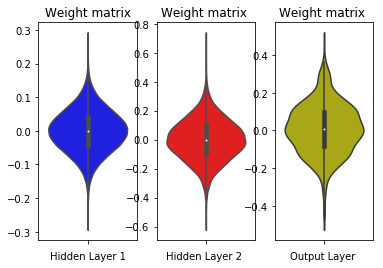

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(501) - ReLu(101) - sigmoid(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 2 + AdamOptimizer + Relu Weights  __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.557873704 test cost=1.553435782
Epoch: 0002 train cost=1.501329075 test cost=1.502011084
Epoch: 0003 train cost=1.488800287 test cost=1.493302651
Epoch: 0004 train cost=1.483503415 test cost=1.488521431
Epoch: 0005 train cost=1.478544128 test cost=1.486121027
Epoch: 0006 train cost=1.475802252 test cost=1.484562435
Epoch: 0007 train cost=1.473638532 test cost=1.484103108
Epoch: 0008 train cost=1.472099081 test cost=1.483053048
Epoch: 0009 train cost=1.471280763 test cost=1.482733827
Epoch: 0010 train cost=1.470020067 test cost=1.482152621
Epoch: 0011 train cost=1.469320133 test cost=1.482001793
Epoch: 0012 train cost=1.468618335 test cost=1.481564953
Epoch: 0013 train cost=1.467969389 test cost=1.481579794
Epoch: 0014 train cost=1.467609548 test cost=1.480826263
Epoch: 0015 train cost=1.467014841 test cos

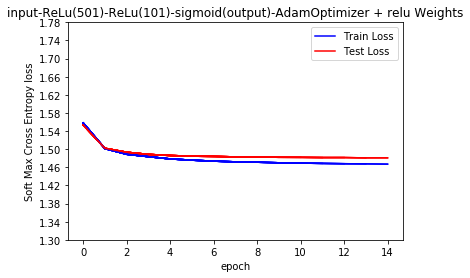

In [0]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

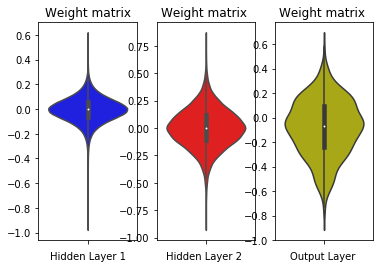

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Input-ReLu(501)-ReLu(101)-sigmoid(output) - GradientDescentOptimizer +relu Weights__

Epoch: 0001 train cost=2.324183183 test cost=2.320480660
Epoch: 0002 train cost=2.228323881 test cost=2.223889344
Epoch: 0003 train cost=2.131201457 test cost=2.125178604
Epoch: 0004 train cost=2.070972846 test cost=2.065256399
Epoch: 0005 train cost=2.026654769 test cost=2.023328576
Epoch: 0006 train cost=1.995614050 test cost=1.990951279
Epoch: 0007 train cost=1.969110420 test cost=1.964853465
Epoch: 0008 train cost=1.948032406 test cost=1.943333615
Epoch: 0009 train cost=1.929267196 test cost=1.925550863
Epoch: 0010 train cost=1.914203826 test cost=1.910704586
Epoch: 0011 train cost=1.901303286 test cost=1.898119073
Epoch: 0012 train cost=1.891655244 test cost=1.887396956
Epoch: 0013 train cost=1.880597345 test cost=1.877990256
Epoch: 0014 train cost=1.871968962 test cost=1.869695024
Epoch: 0015 train cost=1.866121418 test cost=1.862307411
Accuracy: 0.6606


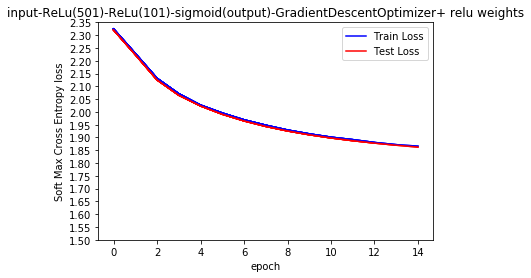

In [0]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(501)-ReLu(101)-sigmoid(output)-GradientDescentOptimizer+ relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

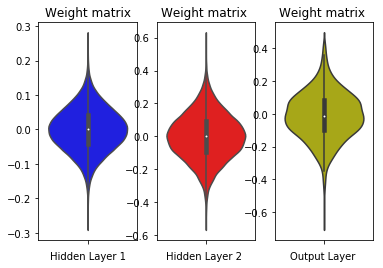

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 2 + AdamOptimizer + sgd Weights  __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.572632789 test cost=1.567157940
Epoch: 0002 train cost=1.505368557 test cost=1.504406741
Epoch: 0003 train cost=1.491428801 test cost=1.493609297
Epoch: 0004 train cost=1.484467720 test cost=1.488734715
Epoch: 0005 train cost=1.480152713 test cost=1.485873918
Epoch: 0006 train cost=1.477288306 test cost=1.484103342
Epoch: 0007 train cost=1.474782788 test cost=1.483048748
Epoch: 0008 train cost=1.473173090 test cost=1.482199336
Epoch: 0009 train cost=1.471800567 test cost=1.481423636
Epoch: 0010 train cost=1.470593800 test cost=1.481046006
Epoch: 0011 train cost=1.469609600 test cost=1.480614005
Epoch: 0012 train cost=1.468397046 test cost=1.480392242
Epoch: 0013 train cost=1.467986877 test cost=1.480571222
Epoch: 0014 train cost=1.467822743 test cost=1.480185220
Epoch: 0015 train cost=1.467235097 test cos

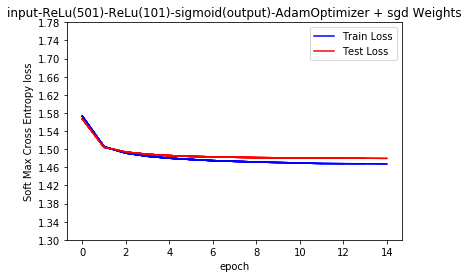

In [0]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ysgd = multilayer_perceptron_relu(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ysgd, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

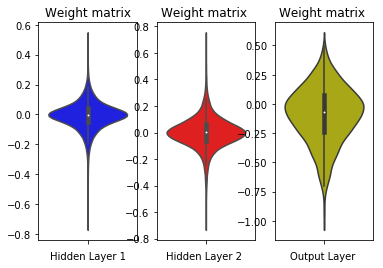

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Input-ReLu(501)-ReLu(101)-sigmoid(output) - GradientDescentOptimizer +sgd Weights__

Epoch: 0001 train cost=2.307690836 test cost=2.305118728
Epoch: 0002 train cost=2.251908951 test cost=2.247721184
Epoch: 0003 train cost=2.198608598 test cost=2.193915227
Epoch: 0004 train cost=2.152209527 test cost=2.147216015
Epoch: 0005 train cost=2.111002432 test cost=2.105082771
Epoch: 0006 train cost=2.073243852 test cost=2.066642245
Epoch: 0007 train cost=2.038553423 test cost=2.030626929
Epoch: 0008 train cost=2.004915015 test cost=1.997488725
Epoch: 0009 train cost=1.975878435 test cost=1.967316701
Epoch: 0010 train cost=1.948853126 test cost=1.940219830
Epoch: 0011 train cost=1.924465878 test cost=1.916267298
Epoch: 0012 train cost=1.903562827 test cost=1.895062512
Epoch: 0013 train cost=1.884719590 test cost=1.876152469
Epoch: 0014 train cost=1.866962155 test cost=1.859182642
Epoch: 0015 train cost=1.852810308 test cost=1.844087934
Accuracy: 0.7854


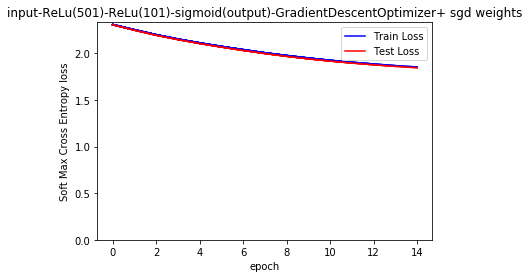

In [0]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input-ReLu(501)-ReLu(101)-sigmoid(output)-GradientDescentOptimizer+ sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input-ReLu(501)-ReLu(101)-sigmoid(output)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

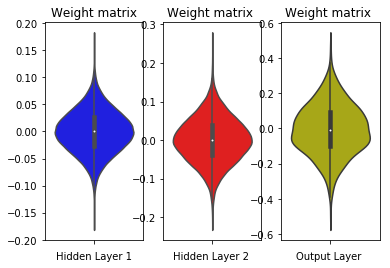

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(501)) - Sigmoid(BatchNormalization(101))- Sigmoid(output) </h3>

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer+SGD Weights  __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.732216060 test cost=1.723742619
Epoch: 0002 train cost=1.556317914 test cost=1.552946369
Epoch: 0003 train cost=1.515836209 test cost=1.515487605
Epoch: 0004 train cost=1.499977340 test cost=1.501811681
Epoch: 0005 train cost=1.490877666 test cost=1.494761830
Epoch: 0006 train cost=1.485730693 test cost=1.491371107
Epoch: 0007 train cost=1.481899467 test cost=1.488741024
Epoch: 0008 train cost=1.479266007 test cost=1.486878612
Epoch: 0009 train cost=1.476417521 test cost=1.485099839
Epoch: 0010 train cost=1.474987323 test cost=1.484316729
Epoch: 0011 train cost=1.473770575 test cost=1.483143957
Epoch: 0012 train cost=1.472509348 test cost=1.482922037
Epoch: 0013 train cost=1.470736934 test cost=1.482282311
Epoch: 0014 train cost=1.470257172 test cost=1.481780304
Epoch: 0015 train cost=1.469559124 test cos

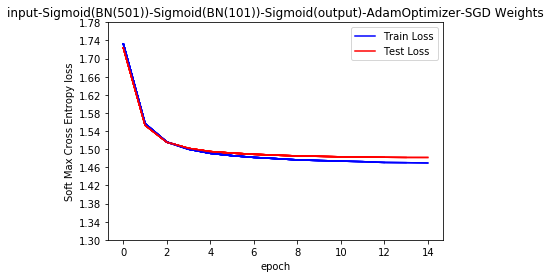

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

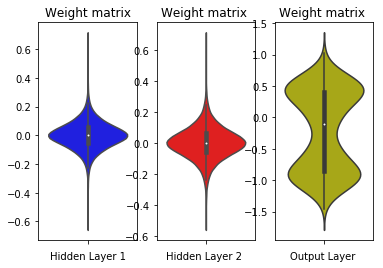

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.297893929 test cost=2.297123655
Epoch: 0002 train cost=2.256942077 test cost=2.254013393
Epoch: 0003 train cost=2.218847473 test cost=2.215833801
Epoch: 0004 train cost=2.187649024 test cost=2.183779638
Epoch: 0005 train cost=2.160287621 test cost=2.156778720
Epoch: 0006 train cost=2.138214025 test cost=2.133433947
Epoch: 0007 train cost=2.116791977 test cost=2.112847314
Epoch: 0008 train cost=2.099154085 test cost=2.094468680
Epoch: 0009 train cost=2.082588086 test cost=2.077853279
Epoch: 0010 train cost=2.067783452 test cost=2.062779625
Epoch: 0011 train cost=2.054300730 test cost=2.049067134
Epoch: 0012 train cost=2.041284358 test cost=2.036527232
Epoch: 0013 train cost=2.030484719 test cost=2.025095405
Epoch: 0014 train cost=2.019799672 test cost=2.014611819
Epoch: 0015 train cost=2.010417833 test cost=2.004952948
Accuracy: 0.8023


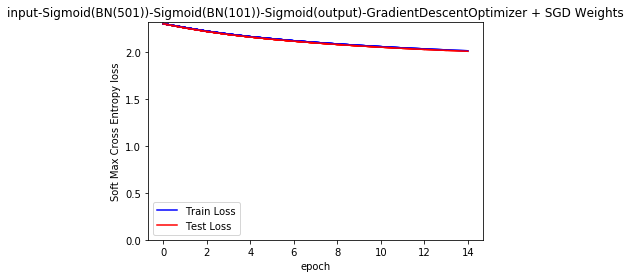

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

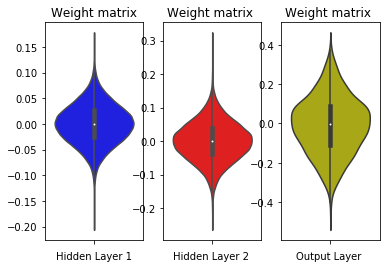

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3+ AdamOptimizer+Relu Weights  __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.724667163 test cost=1.716626631
Epoch: 0002 train cost=1.569265567 test cost=1.564884745
Epoch: 0003 train cost=1.522334751 test cost=1.521926631
Epoch: 0004 train cost=1.504372747 test cost=1.505205639
Epoch: 0005 train cost=1.493964827 test cost=1.497463693
Epoch: 0006 train cost=1.487693658 test cost=1.492610734
Epoch: 0007 train cost=1.483440235 test cost=1.489548663
Epoch: 0008 train cost=1.480208982 test cost=1.487428813
Epoch: 0009 train cost=1.478402168 test cost=1.486033732
Epoch: 0010 train cost=1.475573249 test cost=1.484810306
Epoch: 0011 train cost=1.473881426 test cost=1.483656266
Epoch: 0012 train cost=1.472415197 test cost=1.483111338
Epoch: 0013 train cost=1.472245646 test cost=1.483161871
Epoch: 0014 train cost=1.470835053 test cost=1.482666518
Epoch: 0015 train cost=1.470133320 test cos

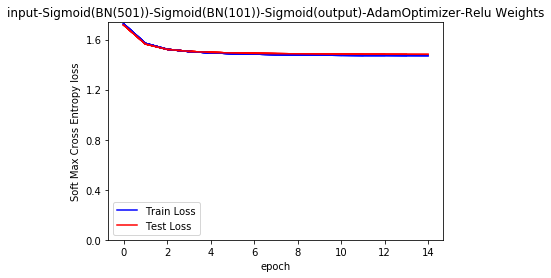

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-Relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-Relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

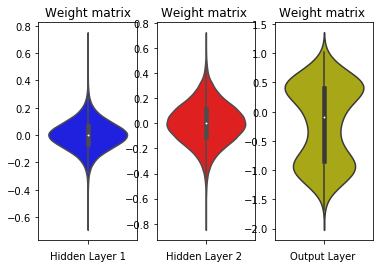

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +Relu Weights __

Epoch: 0001 train cost=2.328460254 test cost=2.330913848
Epoch: 0002 train cost=2.311734247 test cost=2.314557388
Epoch: 0003 train cost=2.296895541 test cost=2.297987549
Epoch: 0004 train cost=2.280262289 test cost=2.281220587
Epoch: 0005 train cost=2.263371869 test cost=2.264355295
Epoch: 0006 train cost=2.247805787 test cost=2.247376803
Epoch: 0007 train cost=2.230496236 test cost=2.230272555
Epoch: 0008 train cost=2.213788227 test cost=2.213321224
Epoch: 0009 train cost=2.197541559 test cost=2.196741897
Epoch: 0010 train cost=2.182509825 test cost=2.180948544
Epoch: 0011 train cost=2.168514884 test cost=2.166226580
Epoch: 0012 train cost=2.154475938 test cost=2.152676781
Epoch: 0013 train cost=2.142288448 test cost=2.140239817
Epoch: 0014 train cost=2.131970597 test cost=2.128721354
Epoch: 0015 train cost=2.121070905 test cost=2.117994017
Accuracy: 0.6325


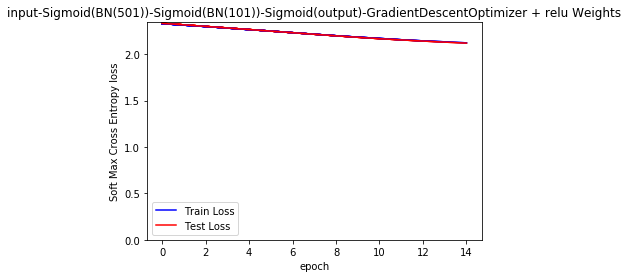

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

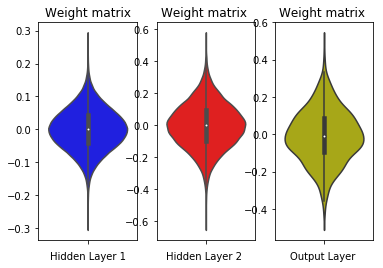

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(501) - Dropout - ReLu(101)- Dropout -Sigmoid(output) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer+relu Weights __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.699757317 test cost=1.612534983
Epoch: 0002 train cost=1.558995169 test cost=1.519308179
Epoch: 0003 train cost=1.533320933 test cost=1.505314441
Epoch: 0004 train cost=1.520717729 test cost=1.498954567
Epoch: 0005 train cost=1.514452830 test cost=1.494458332
Epoch: 0006 train cost=1.507298676 test cost=1.490868991
Epoch: 0007 train cost=1.503825103 test cost=1.488711401
Epoch: 0008 train cost=1.500592629 test cost=1.486680382
Epoch: 0009 train cost=1.497245624 test cost=1.485498400
Epoch: 0010 train cost=1.495131439 test cost=1.484809287
Epoch: 0011 train cost=1.493594003 test cost=1.483945454
Epoch: 0012 train cost=1.492396177 test cost=1.482760983
Epoch: 0013 train cost=1.490587158 test cost=1.482318608
Epoch: 0014 train cost=1.489396888 test cost=1.481789068
Epoch: 0015 train cost=1.488048609 test cos

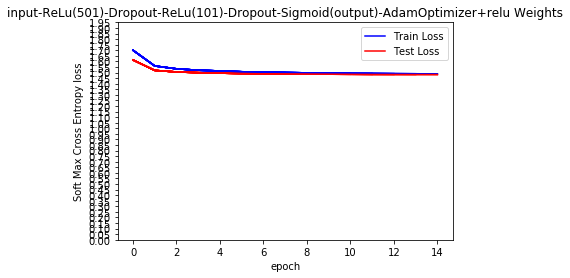

In [0]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer +relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

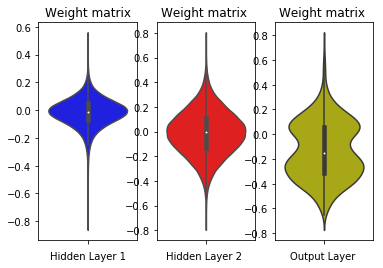

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

__ Model 4 +  GradientDescentOptimizer +relu Weights __

Epoch: 0001 train cost=2.369702177 test cost=2.340802985
Epoch: 0002 train cost=2.351701894 test cost=2.301634726
Epoch: 0003 train cost=2.337930564 test cost=2.266311772
Epoch: 0004 train cost=2.320110380 test cost=2.239682241
Epoch: 0005 train cost=2.307179338 test cost=2.221692558
Epoch: 0006 train cost=2.297386754 test cost=2.208789636
Epoch: 0007 train cost=2.287082608 test cost=2.197866955
Epoch: 0008 train cost=2.273460452 test cost=2.185910875
Epoch: 0009 train cost=2.262777942 test cost=2.171243446
Epoch: 0010 train cost=2.250978554 test cost=2.153232210
Epoch: 0011 train cost=2.238776442 test cost=2.133604036
Epoch: 0012 train cost=2.229217638 test cost=2.111770675
Epoch: 0013 train cost=2.215767058 test cost=2.086769175
Epoch: 0014 train cost=2.202947328 test cost=2.062108855
Epoch: 0015 train cost=2.189867583 test cost=2.037700601
Accuracy: 0.5479


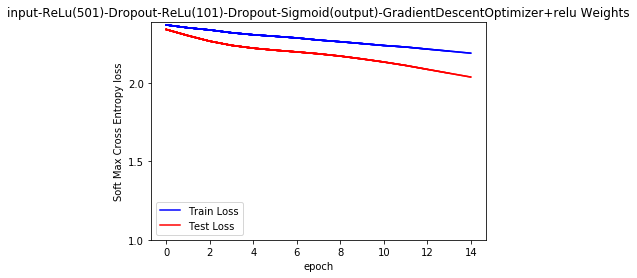

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

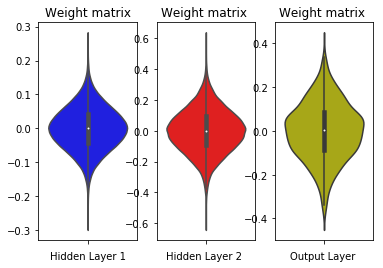

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

__ Model 4 + AdamOptimizer+sgd Weights __

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.664887608 test cost=1.601925527
Epoch: 0002 train cost=1.543496351 test cost=1.514388607
Epoch: 0003 train cost=1.523079604 test cost=1.501952426
Epoch: 0004 train cost=1.512796290 test cost=1.495503905
Epoch: 0005 train cost=1.505933012 test cost=1.491417709
Epoch: 0006 train cost=1.501844907 test cost=1.488908680
Epoch: 0007 train cost=1.498574203 test cost=1.486607353
Epoch: 0008 train cost=1.495828881 test cost=1.484956398
Epoch: 0009 train cost=1.493378981 test cost=1.484465466
Epoch: 0010 train cost=1.492104216 test cost=1.482945799
Epoch: 0011 train cost=1.490278404 test cost=1.482798369
Epoch: 0012 train cost=1.488658177 test cost=1.482119111
Epoch: 0013 train cost=1.488159137 test cost=1.481633457
Epoch: 0014 train cost=1.487598997 test cost=1.481295495
Epoch: 0015 train cost=1.485911855 test cos

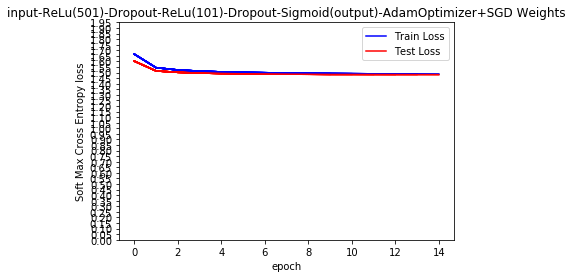

In [0]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer+SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer +SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

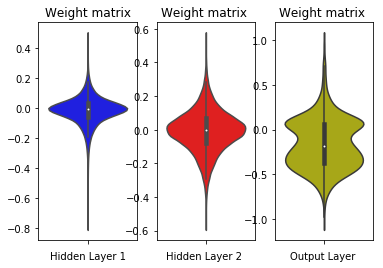

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

__ Model 4 +  GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.349073557 test cost=2.331789417
Epoch: 0002 train cost=2.334647367 test cost=2.304309415
Epoch: 0003 train cost=2.318029637 test cost=2.275009515
Epoch: 0004 train cost=2.302081661 test cost=2.246955307
Epoch: 0005 train cost=2.284341693 test cost=2.221860733
Epoch: 0006 train cost=2.267981768 test cost=2.198096539
Epoch: 0007 train cost=2.253209795 test cost=2.175348655
Epoch: 0008 train cost=2.238156659 test cost=2.152695925
Epoch: 0009 train cost=2.222730946 test cost=2.130102716
Epoch: 0010 train cost=2.205977190 test cost=2.107507694
Epoch: 0011 train cost=2.193724774 test cost=2.086329952
Epoch: 0012 train cost=2.178918477 test cost=2.066026856
Epoch: 0013 train cost=2.164933179 test cost=2.046828395
Epoch: 0014 train cost=2.148401600 test cost=2.028307865
Epoch: 0015 train cost=2.137735576 test cost=2.010118957
Accuracy: 0.6566


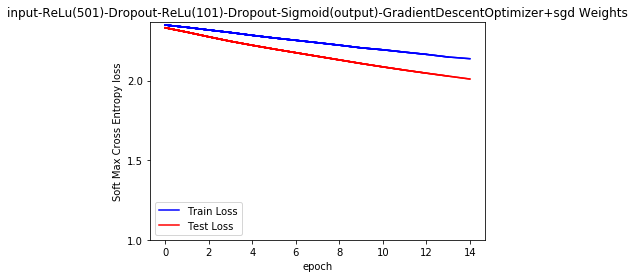

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer+sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer + wgd Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

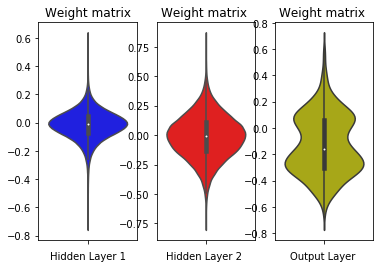

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

Model 5: Input - Relu(BatchNormalization(501)) - Relu(BatchNormalization(101))- Relu(output) 

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Relu activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    	
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Relu activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Relu activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

**Model 5+ AdamOptimizer+relu weights**

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.466650956 test cost=0.443246003
Epoch: 0002 train cost=0.188231570 test cost=0.192950925
Epoch: 0003 train cost=0.053916186 test cost=0.075929161
Epoch: 0004 train cost=0.033282292 test cost=0.067636467
Epoch: 0005 train cost=0.027568048 test cost=0.070662207
Epoch: 0006 train cost=0.019144254 test cost=0.067470308
Epoch: 0007 train cost=0.016612454 test cost=0.066874973
Epoch: 0008 train cost=0.015425177 test cost=0.073422279
Epoch: 0009 train cost=0.011559528 test cost=0.072172350
Epoch: 0010 train cost=0.010709947 test cost=0.074329880
Epoch: 0011 train cost=0.012196048 test cost=0.075731182
Epoch: 0012 train cost=0.009777243 test cost=0.072355954
Epoch: 0013 train cost=0.009574527 test cost=0.072361779
Epoch: 0014 train cost=0.007305421 test cost=0.069225525
Epoch: 0015 train cost=0.007711425 test cos

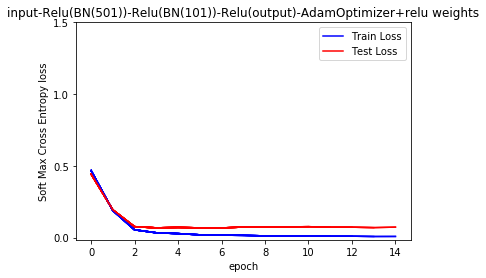

In [0]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


Text(0.5, 0, 'Output Layer ')

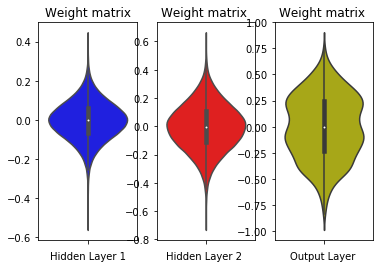

In [0]:
import seaborn as sns

h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

**__** Model 5 + GradientDescentOptimizer +relu weights  __

Epoch: 0001 train cost=2.054821582 test cost=2.033431185
Epoch: 0002 train cost=1.522899010 test cost=1.492384556
Epoch: 0003 train cost=1.256457850 test cost=1.219719633
Epoch: 0004 train cost=1.093917026 test cost=1.056934479
Epoch: 0005 train cost=0.983021607 test cost=0.945214717
Epoch: 0006 train cost=0.900948217 test cost=0.865362933
Epoch: 0007 train cost=0.839210311 test cost=0.806314127
Epoch: 0008 train cost=0.790017741 test cost=0.758695800
Epoch: 0009 train cost=0.745869862 test cost=0.713842669
Epoch: 0010 train cost=0.694983761 test cost=0.663049920
Epoch: 0011 train cost=0.637073117 test cost=0.602482634
Epoch: 0012 train cost=0.581373639 test cost=0.542586182
Epoch: 0013 train cost=0.531374950 test cost=0.492488322
Epoch: 0014 train cost=0.491513546 test cost=0.453605113
Epoch: 0015 train cost=0.460078445 test cost=0.424478225
Accuracy: 0.8961


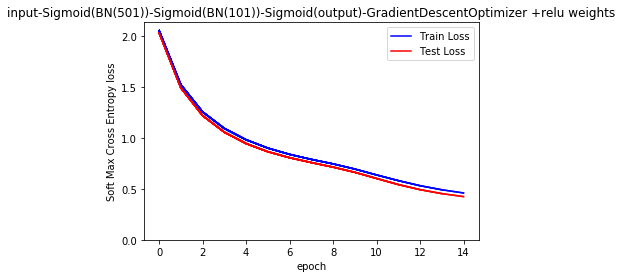

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

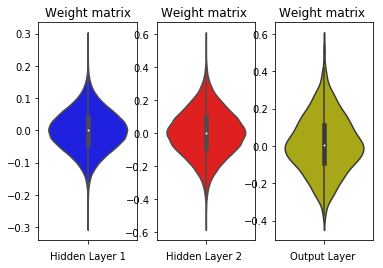

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 5+ AdamOptimizer+sgd weights**

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.902233433 test cost=0.872320463
Epoch: 0002 train cost=0.768817931 test cost=0.763625901
Epoch: 0003 train cost=0.739637385 test cost=0.750395652
Epoch: 0004 train cost=0.724308101 test cost=0.744066507
Epoch: 0005 train cost=0.719091458 test cost=0.743187513
Epoch: 0006 train cost=0.714938467 test cost=0.743395613
Epoch: 0007 train cost=0.710237070 test cost=0.743325651
Epoch: 0008 train cost=0.709763743 test cost=0.743194147
Epoch: 0009 train cost=0.707451369 test cost=0.744789004
Epoch: 0010 train cost=0.706141919 test cost=0.744667367
Epoch: 0011 train cost=0.704835168 test cost=0.745369170
Epoch: 0012 train cost=0.705082136 test cost=0.744883157
Epoch: 0013 train cost=0.705131387 test cost=0.744846403
Epoch: 0014 train cost=0.700305530 test cost=0.740740371
Epoch: 0015 train cost=0.702510997 test cos

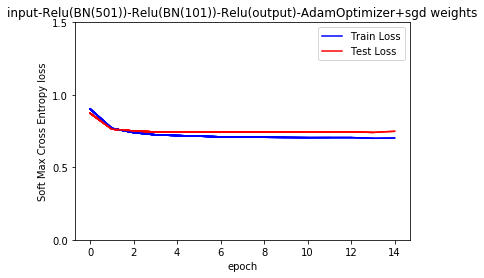

In [0]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


Text(0.5, 0, 'Output Layer ')

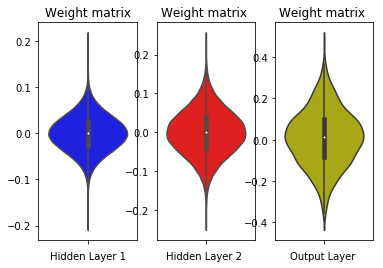

In [0]:
import seaborn as sns

h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

**__** Model 5 + GradientDescentOptimizer +sgd weights  __

Epoch: 0001 train cost=2.202765850 test cost=2.162150460
Epoch: 0002 train cost=1.616870567 test cost=1.569397396
Epoch: 0003 train cost=1.378326521 test cost=1.335351275
Epoch: 0004 train cost=1.235503474 test cost=1.195740049
Epoch: 0005 train cost=1.116397352 test cost=1.077179049
Epoch: 0006 train cost=1.010248801 test cost=0.969646598
Epoch: 0007 train cost=0.920917171 test cost=0.880741828
Epoch: 0008 train cost=0.853977701 test cost=0.813199975
Epoch: 0009 train cost=0.801991427 test cost=0.762130196
Epoch: 0010 train cost=0.763488604 test cost=0.723097064
Epoch: 0011 train cost=0.731812280 test cost=0.692072449
Epoch: 0012 train cost=0.704325017 test cost=0.666543063
Epoch: 0013 train cost=0.683152339 test cost=0.645369443
Epoch: 0014 train cost=0.665751411 test cost=0.627210639
Epoch: 0015 train cost=0.647431736 test cost=0.611380911
Accuracy: 0.8186


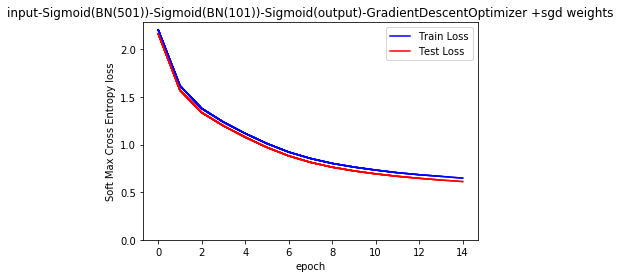

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

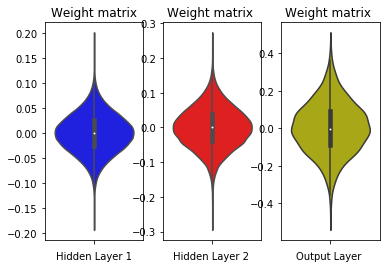

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

***Model 6: Input - ReLu(501) - Dropout - ReLu(101)- Dropout -Relu(output)***

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Relu activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 6 + AdamOptimizer+relu weights

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.872190838 test cost=0.544829783
Epoch: 0002 train cost=0.325145071 test cost=0.178766484
Epoch: 0003 train cost=0.236597997 test cost=0.132924583
Epoch: 0004 train cost=0.194123049 test cost=0.114801675
Epoch: 0005 train cost=0.171282994 test cost=0.102261038
Epoch: 0006 train cost=0.150479970 test cost=0.095461494
Epoch: 0007 train cost=0.135500902 test cost=0.090976259
Epoch: 0008 train cost=0.130047278 test cost=0.088277507
Epoch: 0009 train cost=0.116876189 test cost=0.083896870
Epoch: 0010 train cost=0.109533719 test cost=0.080533283
Epoch: 0011 train cost=0.099071974 test cost=0.078326423
Epoch: 0012 train cost=0.094871763 test cost=0.077213114
Epoch: 0013 train cost=0.095409048 test cost=0.076523519
Epoch: 0014 train cost=0.089105373 test cost=0.075328817
Epoch: 0015 train cost=0.081606932 test cos

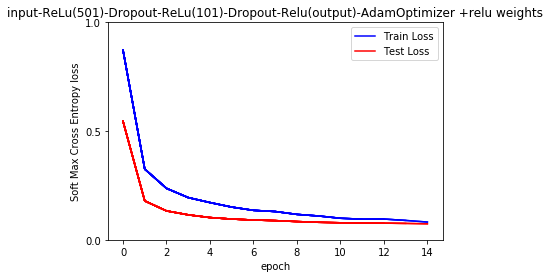

In [0]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

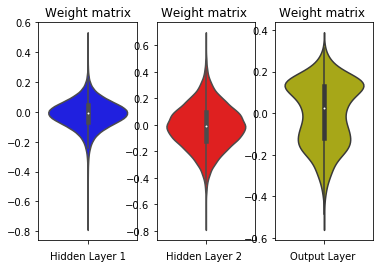

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

![alt text](https://)Model6+ GradientDescentOptimizer+relu weights

Epoch: 0001 train cost=2.976546632 test cost=2.331518757
Epoch: 0002 train cost=2.358995382 test cost=2.302585602
Epoch: 0003 train cost=2.326591723 test cost=2.302585602
Epoch: 0004 train cost=2.318562091 test cost=2.302585602
Epoch: 0005 train cost=2.313401353 test cost=2.302585602
Epoch: 0006 train cost=2.310604826 test cost=2.302585602
Epoch: 0007 train cost=2.307785088 test cost=2.302585602
Epoch: 0008 train cost=2.306797144 test cost=2.302585602
Epoch: 0009 train cost=2.305244138 test cost=2.302585602
Epoch: 0010 train cost=2.304104262 test cost=2.302585602
Epoch: 0011 train cost=2.304096958 test cost=2.302585602
Epoch: 0012 train cost=2.304212590 test cost=2.302585602
Epoch: 0013 train cost=2.303411745 test cost=2.302585602
Epoch: 0014 train cost=2.301133645 test cost=2.302585602
Epoch: 0015 train cost=2.300424403 test cost=2.302585602
Accuracy: 0.098


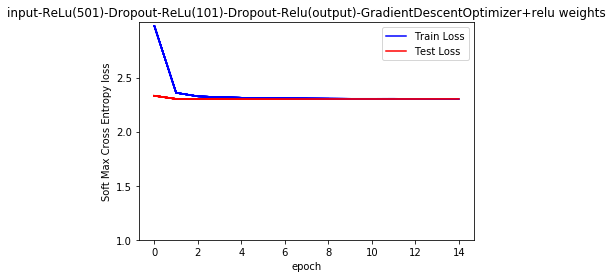

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

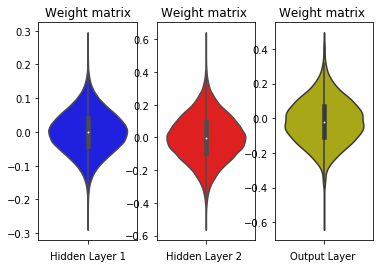

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

Model 6 + AdamOptimizer+sgd weights

x: (?, 784) W[h1]: (784, 501) b[h1]: (501,)
layer_1: (?, 501) W[h2]: (501, 101) b[h2]: (101,)
layer_2: (?, 101) W[out]: (101, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.718489584 test cost=0.518002803
Epoch: 0002 train cost=0.270343456 test cost=0.161456571
Epoch: 0003 train cost=0.208423376 test cost=0.126501908
Epoch: 0004 train cost=0.169639302 test cost=0.107529141
Epoch: 0005 train cost=0.148847207 test cost=0.097934446
Epoch: 0006 train cost=0.133797595 test cost=0.090152646
Epoch: 0007 train cost=0.123083785 test cost=0.084765052
Epoch: 0008 train cost=0.115600622 test cost=0.082013694
Epoch: 0009 train cost=0.107087717 test cost=0.080175082
Epoch: 0010 train cost=0.097827709 test cost=0.077434896
Epoch: 0011 train cost=0.095271255 test cost=0.076988167
Epoch: 0012 train cost=0.090294212 test cost=0.075816567
Epoch: 0013 train cost=0.085150795 test cost=0.074000469
Epoch: 0014 train cost=0.079831796 test cost=0.073904557
Epoch: 0015 train cost=0.077431749 test cos

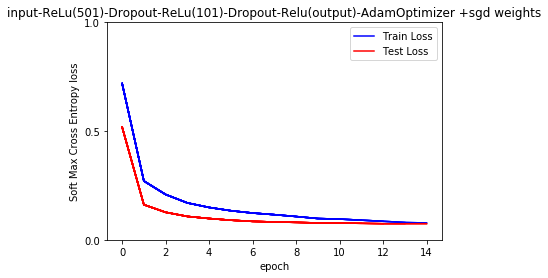

In [0]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

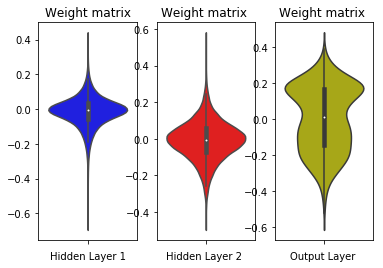

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

Model6+ GradientDescentOptimizer+sgd weights

Epoch: 0001 train cost=2.833423053 test cost=2.409263863
Epoch: 0002 train cost=2.378504947 test cost=2.302451505
Epoch: 0003 train cost=2.332076298 test cost=2.302585602
Epoch: 0004 train cost=2.321026777 test cost=2.302585602
Epoch: 0005 train cost=2.314056931 test cost=2.302585602
Epoch: 0006 train cost=2.308346329 test cost=2.302585602
Epoch: 0007 train cost=2.303441057 test cost=2.302585602
Epoch: 0008 train cost=2.298309756 test cost=2.302585602
Epoch: 0009 train cost=2.289336461 test cost=2.302446554
Epoch: 0010 train cost=2.277055283 test cost=2.284584460
Epoch: 0011 train cost=2.256129395 test cost=2.233121863
Epoch: 0012 train cost=2.233363538 test cost=2.185391684
Epoch: 0013 train cost=2.199075458 test cost=2.135960813
Epoch: 0014 train cost=2.167393979 test cost=2.067639595
Epoch: 0015 train cost=2.127603644 test cost=2.003028242
Accuracy: 0.2955


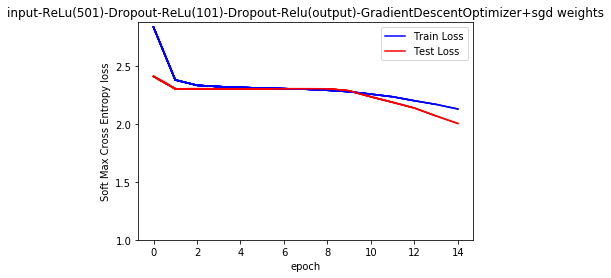

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

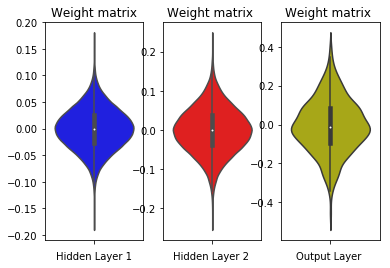

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

<h3>Architecture 2: 784-256-128-64-10</h3>

In [0]:
# Network Parameters

n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_hidden_3 = 64 # 3rd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [0]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [0]:
# Weight initialization

weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.044, mean=0)),    #784x512 # sqrt(2/(784+256)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.072, mean=0)), #512x128 # sqrt(2/(256+128)) = 0.058
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.102, mean=0)), #512x128 # sqrt(2/(128+64)) = 0.058
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes],stddev=0.164, mean=0))  #64x10
}

weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.088, mean=0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.175, mean=0)),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes],stddev=0.163, mean=0))  
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_classes]))              
}

In [0]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

<h3> Model 1: input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) 
softmax(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h2'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        

    # Hidden layer with Sigmoid activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        

    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer with SGD Weight__

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (256, 128) b[h3]: (64,)
layer_3: (?, 128) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.796449683 test cost=1.793307998
Epoch: 0002 train cost=1.568444483 test cost=1.566144861
Epoch: 0003 train cost=1.524917283 test cost=1.524897235
Epoch: 0004 train cost=1.507689301 test cost=1.509242791
Epoch: 0005 train cost=1.497649481 test cost=1.500651589
Epoch: 0006 train cost=1.490644269 test cost=1.496033760
Epoch: 0007 train cost=1.485849367 test cost=1.492545874
Epoch: 0008 train cost=1.482373705 test cost=1.490348492
Epoch: 0009 train cost=1.479130950 test cost=1.488353674
Epoch: 0010 train cost=1.476703414 test cost=1.487341973
Epoch: 0011 train cost=1.474848331 test cost=1.486528879
Epoch: 0012 train cost=1.473258846 test cost=1.485575137
Epoch: 0013 train cost=1.472214286 test cost=1.485168918
Epoch: 0014 train cost=1.470819975 test cost=1.48461

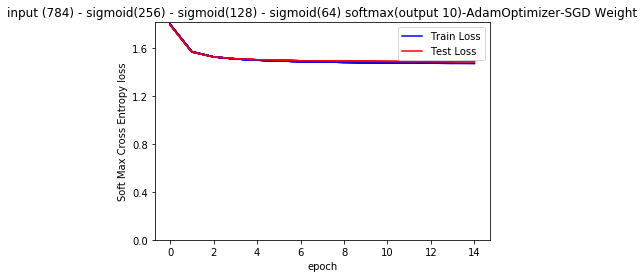

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-AdamOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-AdamOptimizer-SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

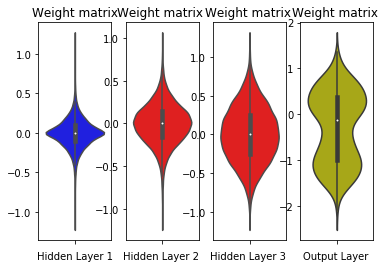

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with SGD Weight__

Epoch: 0001 train cost=2.343655363 test cost=2.346146297
Epoch: 0002 train cost=2.340025336 test cost=2.344300909
Epoch: 0003 train cost=2.339482760 test cost=2.342458971
Epoch: 0004 train cost=2.335413196 test cost=2.340626001
Epoch: 0005 train cost=2.338297724 test cost=2.338851370
Epoch: 0006 train cost=2.331765031 test cost=2.337131628
Epoch: 0007 train cost=2.333859774 test cost=2.335490598
Epoch: 0008 train cost=2.330227443 test cost=2.333897131
Epoch: 0009 train cost=2.329806490 test cost=2.332427463
Epoch: 0010 train cost=2.327950023 test cost=2.331045428
Epoch: 0011 train cost=2.325736169 test cost=2.329752517
Epoch: 0012 train cost=2.326954745 test cost=2.328562021
Epoch: 0013 train cost=2.324750191 test cost=2.327425828
Epoch: 0014 train cost=2.323050739 test cost=2.326390723
Epoch: 0015 train cost=2.324437594 test cost=2.325404210
Accuracy: 0.098


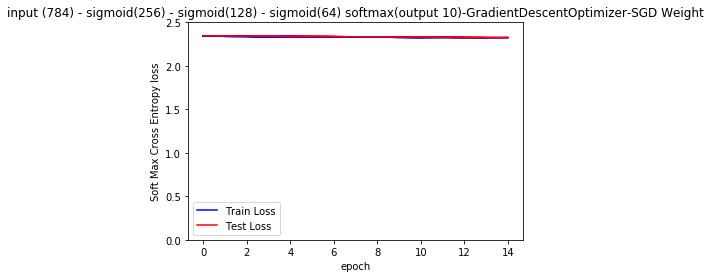

In [0]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-GradientDescentOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-GradientDescentOptimizer- SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

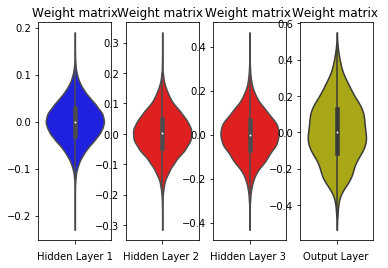

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + AdamOptimizer with Relu Weight__

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (256, 128) b[h3]: (64,)
layer_3: (?, 128) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.773215842 test cost=1.767972195
Epoch: 0002 train cost=1.551780114 test cost=1.550704716
Epoch: 0003 train cost=1.517784436 test cost=1.518328517
Epoch: 0004 train cost=1.504180885 test cost=1.505060556
Epoch: 0005 train cost=1.493619039 test cost=1.497350248
Epoch: 0006 train cost=1.487881712 test cost=1.492668347
Epoch: 0007 train cost=1.484590812 test cost=1.489548440
Epoch: 0008 train cost=1.479598733 test cost=1.487616618
Epoch: 0009 train cost=1.477716040 test cost=1.485786097
Epoch: 0010 train cost=1.475554621 test cost=1.485081909
Epoch: 0011 train cost=1.473674900 test cost=1.483895373
Epoch: 0012 train cost=1.471984940 test cost=1.483267648
Epoch: 0013 train cost=1.471013879 test cost=1.482639181
Epoch: 0014 train cost=1.469669116 test cost=1.48209

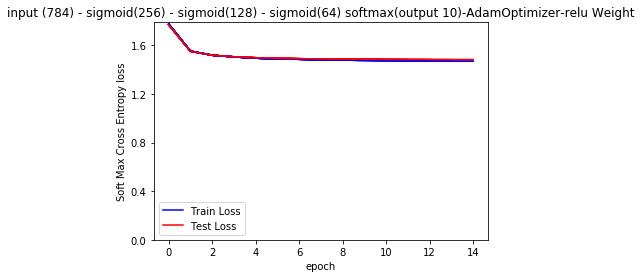

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_relu = multilayer_perceptron(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_relu, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-AdamOptimizer-relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-AdamOptimizer-relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

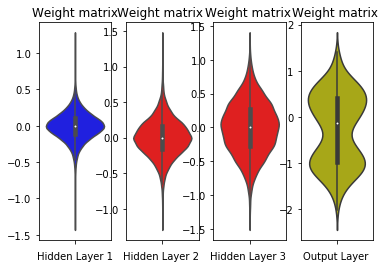

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with relu Weight__

Epoch: 0001 train cost=2.331575355 test cost=2.330674695
Epoch: 0002 train cost=2.328231929 test cost=2.328113639
Epoch: 0003 train cost=2.326108119 test cost=2.325719530
Epoch: 0004 train cost=2.324022191 test cost=2.323474773
Epoch: 0005 train cost=2.322278395 test cost=2.321365515
Epoch: 0006 train cost=2.319401087 test cost=2.319453566
Epoch: 0007 train cost=2.318726627 test cost=2.317684630
Epoch: 0008 train cost=2.315722182 test cost=2.316051503
Epoch: 0009 train cost=2.314926649 test cost=2.314575429
Epoch: 0010 train cost=2.313912908 test cost=2.313231753
Epoch: 0011 train cost=2.312402312 test cost=2.311973910
Epoch: 0012 train cost=2.310813935 test cost=2.310855070
Epoch: 0013 train cost=2.310471101 test cost=2.309836713
Epoch: 0014 train cost=2.309059697 test cost=2.308911650
Epoch: 0015 train cost=2.308082911 test cost=2.308068551
Accuracy: 0.098


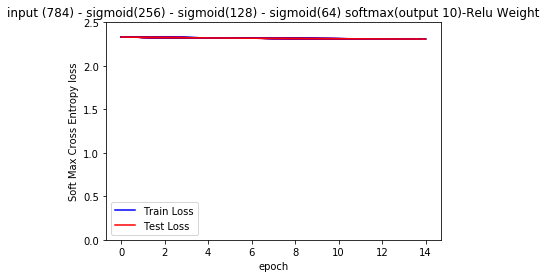

In [0]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-Relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), "input (784) - sigmoid(256) - sigmoid(128) - sigmoid(64) softmax(output 10)-Relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

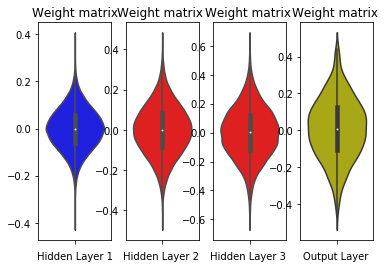

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        

    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        

    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 2 + AdamOptimizer + Relu Weights  __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.563518771 test cost=1.559036469
Epoch: 0002 train cost=1.501535752 test cost=1.500634641
Epoch: 0003 train cost=1.489954770 test cost=1.492476439
Epoch: 0004 train cost=1.483896819 test cost=1.487458294
Epoch: 0005 train cost=1.478709051 test cost=1.485177730
Epoch: 0006 train cost=1.476816116 test cost=1.483904349
Epoch: 0007 train cost=1.475080001 test cost=1.482683519
Epoch: 0008 train cost=1.472634783 test cost=1.482072922
Epoch: 0009 train cost=1.471549781 test cost=1.482125207
Epoch: 0010 train cost=1.470762955 test cost=1.481249081
Epoch: 0011 train cost=1.470696404 test cost=1.480788818
Epoch: 0012 train cost=1.469323099 test cost=1.480993642
Epoch: 0013 train cost=1.468572400 test cost=1.481021310
Epoch: 0014 train cost=1.468576229 test cost=1.4813267

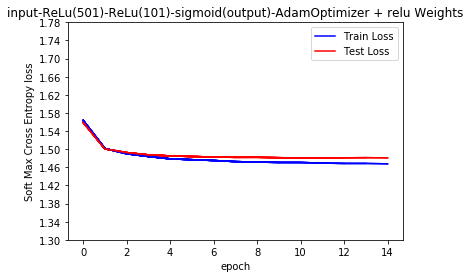

In [0]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(501)-ReLu(101)-sigmoid(output)-AdamOptimizer + relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

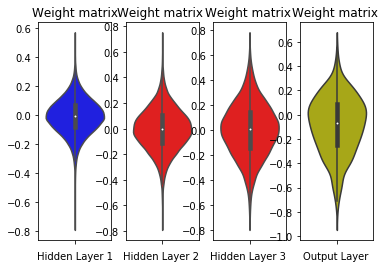

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model2- GradientDescentOptimizer +relu Weights__

Epoch: 0001 train cost=2.341198485 test cost=2.339492719
Epoch: 0002 train cost=2.278868859 test cost=2.273287758
Epoch: 0003 train cost=2.205402337 test cost=2.199077670
Epoch: 0004 train cost=2.123334943 test cost=2.116439565
Epoch: 0005 train cost=2.051439233 test cost=2.042950805
Epoch: 0006 train cost=1.997080969 test cost=1.988984606
Epoch: 0007 train cost=1.953112083 test cost=1.944223357
Epoch: 0008 train cost=1.915148987 test cost=1.906807786
Epoch: 0009 train cost=1.884662934 test cost=1.875341631
Epoch: 0010 train cost=1.857078595 test cost=1.848857454
Epoch: 0011 train cost=1.834954717 test cost=1.826441146
Epoch: 0012 train cost=1.815967999 test cost=1.807393507
Epoch: 0013 train cost=1.797892513 test cost=1.791119116
Epoch: 0014 train cost=1.786246594 test cost=1.776972363
Epoch: 0015 train cost=1.771959290 test cost=1.764575715
Accuracy: 0.7788


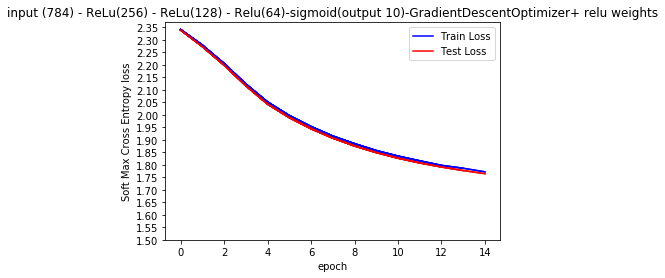

In [0]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-GradientDescentOptimizer+ relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

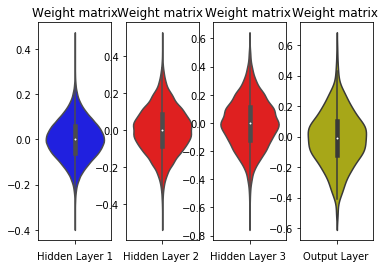

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 2 + AdamOptimizer + sgd Weights  __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.586010719 test cost=1.580904295
Epoch: 0002 train cost=1.505377412 test cost=1.504934001
Epoch: 0003 train cost=1.492218929 test cost=1.494352490
Epoch: 0004 train cost=1.486307589 test cost=1.489395517
Epoch: 0005 train cost=1.481413730 test cost=1.486168814
Epoch: 0006 train cost=1.478593916 test cost=1.484882643
Epoch: 0007 train cost=1.476336911 test cost=1.483381021
Epoch: 0008 train cost=1.474099527 test cost=1.482977780
Epoch: 0009 train cost=1.473112923 test cost=1.482289713
Epoch: 0010 train cost=1.471600590 test cost=1.482467626
Epoch: 0011 train cost=1.471739484 test cost=1.481949549
Epoch: 0012 train cost=1.469294306 test cost=1.480533754
Epoch: 0013 train cost=1.469667258 test cost=1.481720336
Epoch: 0014 train cost=1.468450241 test cost=1.4805278

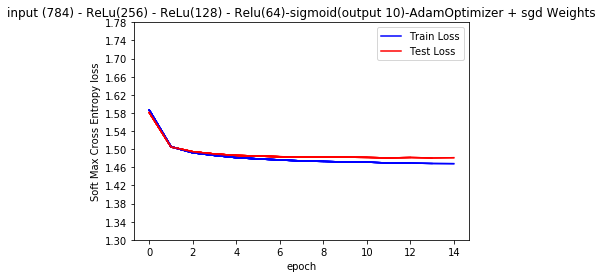

In [0]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ysgd = multilayer_perceptron_relu(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ysgd, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-AdamOptimizer + sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-AdamOptimizer + sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

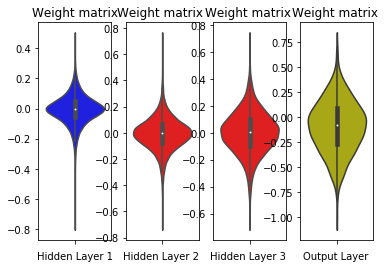

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Model2 - GradientDescentOptimizer +sgd Weights__

Epoch: 0001 train cost=2.302367412 test cost=2.302068414
Epoch: 0002 train cost=2.269285150 test cost=2.268358247
Epoch: 0003 train cost=2.240182376 test cost=2.238414318
Epoch: 0004 train cost=2.212293172 test cost=2.210356894
Epoch: 0005 train cost=2.184320253 test cost=2.182227005
Epoch: 0006 train cost=2.156201906 test cost=2.153523276
Epoch: 0007 train cost=2.127504667 test cost=2.124274863
Epoch: 0008 train cost=2.099083502 test cost=2.094640685
Epoch: 0009 train cost=2.069454302 test cost=2.064496754
Epoch: 0010 train cost=2.039323031 test cost=2.035045011
Epoch: 0011 train cost=2.011905035 test cost=2.007015397
Epoch: 0012 train cost=1.987355570 test cost=1.980584701
Epoch: 0013 train cost=1.961537940 test cost=1.955908592
Epoch: 0014 train cost=1.938729839 test cost=1.932947573
Epoch: 0015 train cost=1.918109721 test cost=1.911797216
Accuracy: 0.7529


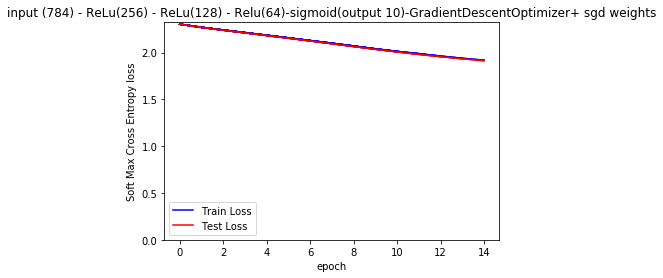

In [0]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-GradientDescentOptimizer+ sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "input (784) - ReLu(256) - ReLu(128) - Relu(64)-sigmoid(output 10)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

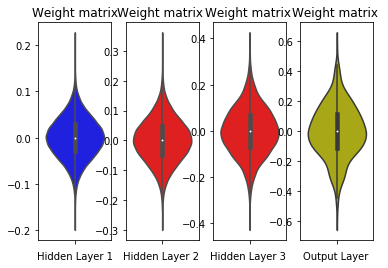

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(256)) - Sigmoid(BatchNormalization(128))-Sigmoid(BatchNormalization(64))- Sigmoid(output) </h3>

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    ######################################################################################

    # Hidden layer with Sigmoid activation and batch normalization
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, beta_3, scale_3, epsilon)
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        
    
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer+SGD Weights  __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.777200962 test cost=1.769316378
Epoch: 0002 train cost=1.569230709 test cost=1.564116138
Epoch: 0003 train cost=1.520354413 test cost=1.519156630
Epoch: 0004 train cost=1.503651233 test cost=1.503245689
Epoch: 0005 train cost=1.491724545 test cost=1.494773144
Epoch: 0006 train cost=1.486972720 test cost=1.490568101
Epoch: 0007 train cost=1.482470139 test cost=1.487481478
Epoch: 0008 train cost=1.479749398 test cost=1.485288071
Epoch: 0009 train cost=1.476998030 test cost=1.483799534
Epoch: 0010 train cost=1.475376698 test cost=1.482904986
Epoch: 0011 train cost=1.473689674 test cost=1.481664906
Epoch: 0012 train cost=1.472830012 test cost=1.480840846
Epoch: 0013 train cost=1.471597070 test cost=1.480772611
Epoch: 0014 train cost=1.470876683 test cost=1.4808171

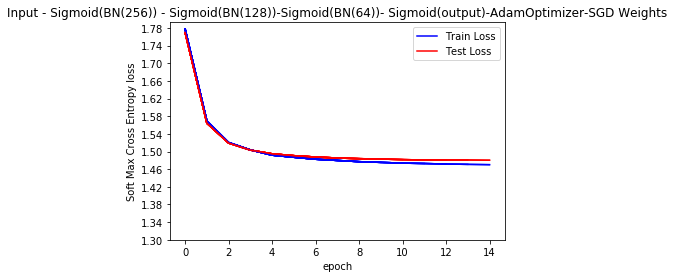

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-AdamOptimizer-SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-AdamOptimizer-SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

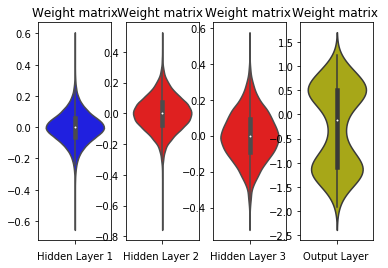

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.344681272 test cost=2.343754212
Epoch: 0002 train cost=2.320370746 test cost=2.320951460
Epoch: 0003 train cost=2.300816737 test cost=2.298261149
Epoch: 0004 train cost=2.276155246 test cost=2.276114823
Epoch: 0005 train cost=2.256226983 test cost=2.254610203
Epoch: 0006 train cost=2.236178497 test cost=2.234009785
Epoch: 0007 train cost=2.216966108 test cost=2.214889823
Epoch: 0008 train cost=2.200496884 test cost=2.197710277
Epoch: 0009 train cost=2.185501517 test cost=2.182484679
Epoch: 0010 train cost=2.171152442 test cost=2.168851858
Epoch: 0011 train cost=2.161152279 test cost=2.156456903
Epoch: 0012 train cost=2.147823442 test cost=2.144910397
Epoch: 0013 train cost=2.137657091 test cost=2.133995618
Epoch: 0014 train cost=2.127274775 test cost=2.123612680
Epoch: 0015 train cost=2.117612868 test cost=2.113699650
Accuracy: 0.2944


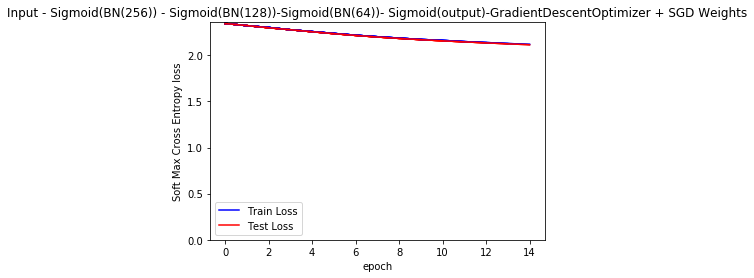

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

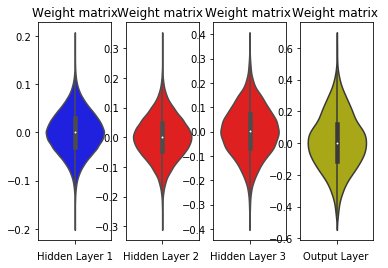

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3+ AdamOptimizer+Relu Weights  __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.788765884 test cost=1.781078857
Epoch: 0002 train cost=1.576606611 test cost=1.572777011
Epoch: 0003 train cost=1.524971366 test cost=1.522989515
Epoch: 0004 train cost=1.504939510 test cost=1.505718808
Epoch: 0005 train cost=1.494460581 test cost=1.496869468
Epoch: 0006 train cost=1.487944929 test cost=1.491675646
Epoch: 0007 train cost=1.483410455 test cost=1.488271021
Epoch: 0008 train cost=1.480284467 test cost=1.486312581
Epoch: 0009 train cost=1.477327417 test cost=1.484726213
Epoch: 0010 train cost=1.475840505 test cost=1.483886043
Epoch: 0011 train cost=1.474219625 test cost=1.482700604
Epoch: 0012 train cost=1.473048272 test cost=1.481404204
Epoch: 0013 train cost=1.471984336 test cost=1.481373877
Epoch: 0014 train cost=1.471003972 test cost=1.4812815

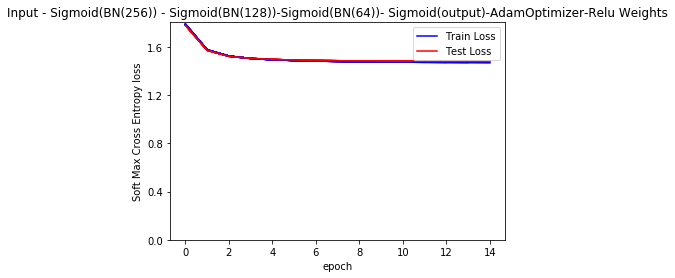

In [0]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-AdamOptimizer-Relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-AdamOptimizer-Relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

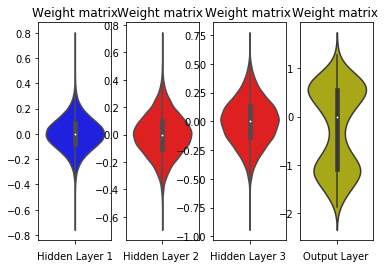

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +Relu Weights __

Epoch: 0001 train cost=2.332046794 test cost=2.331578789
Epoch: 0002 train cost=2.323851377 test cost=2.321731182
Epoch: 0003 train cost=2.312823916 test cost=2.311695687
Epoch: 0004 train cost=2.302963083 test cost=2.301510323
Epoch: 0005 train cost=2.293689495 test cost=2.291247919
Epoch: 0006 train cost=2.283626196 test cost=2.280947463
Epoch: 0007 train cost=2.272334567 test cost=2.270606165
Epoch: 0008 train cost=2.262770153 test cost=2.260318360
Epoch: 0009 train cost=2.252890756 test cost=2.250038675
Epoch: 0010 train cost=2.243452034 test cost=2.239880771
Epoch: 0011 train cost=2.232943912 test cost=2.229926372
Epoch: 0012 train cost=2.223321283 test cost=2.220286473
Epoch: 0013 train cost=2.213281032 test cost=2.210985478
Epoch: 0014 train cost=2.205206706 test cost=2.202076385
Epoch: 0015 train cost=2.197441007 test cost=2.193561755
Accuracy: 0.0969


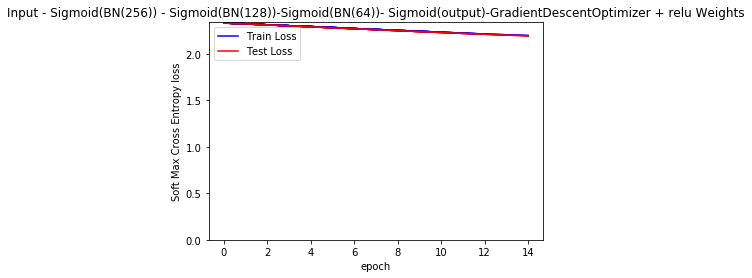

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-GradientDescentOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

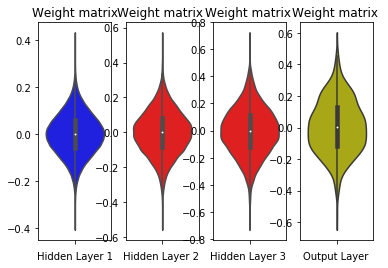

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        

    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2_drop, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_3_drop = tf.nn.dropout(layer_3, rate)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        

    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_3_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer+relu Weights __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.888455644 test cost=1.736025160
Epoch: 0002 train cost=1.647115149 test cost=1.583103561
Epoch: 0003 train cost=1.592539593 test cost=1.542705811
Epoch: 0004 train cost=1.565529011 test cost=1.524544624
Epoch: 0005 train cost=1.546326727 test cost=1.508575758
Epoch: 0006 train cost=1.537370248 test cost=1.503870589
Epoch: 0007 train cost=1.529141132 test cost=1.500331000
Epoch: 0008 train cost=1.524015278 test cost=1.498800531
Epoch: 0009 train cost=1.518366758 test cost=1.496910400
Epoch: 0010 train cost=1.516652629 test cost=1.494462992
Epoch: 0011 train cost=1.512100163 test cost=1.493403846
Epoch: 0012 train cost=1.511427561 test cost=1.492097408
Epoch: 0013 train cost=1.508804696 test cost=1.491247329
Epoch: 0014 train cost=1.506820215 test cost=1.4903558

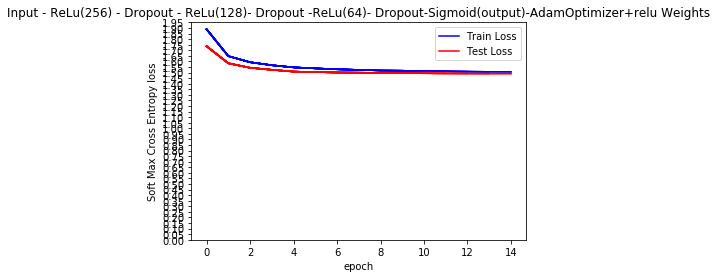

In [0]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-AdamOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-AdamOptimizer +relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

Text(0.5, 0, 'Output Layer ')

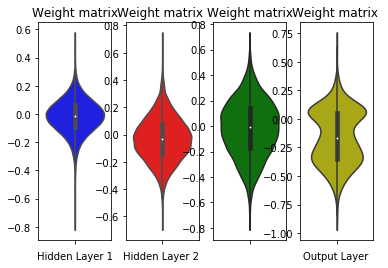

In [0]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix")
ax = sns.violinplot(y=h3_w, color='g')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

__ Model 4 +  GradientDescentOptimizer +relu Weights __

Epoch: 0001 train cost=2.388307415 test cost=2.386734490
Epoch: 0002 train cost=2.384514798 test cost=2.373124728
Epoch: 0003 train cost=2.376240377 test cost=2.357318402
Epoch: 0004 train cost=2.368853079 test cost=2.340377504
Epoch: 0005 train cost=2.360630155 test cost=2.324258784
Epoch: 0006 train cost=2.359024701 test cost=2.313002481
Epoch: 0007 train cost=2.352691946 test cost=2.306768434
Epoch: 0008 train cost=2.349798733 test cost=2.303876229
Epoch: 0009 train cost=2.339542084 test cost=2.301705698
Epoch: 0010 train cost=2.334044597 test cost=2.299283596
Epoch: 0011 train cost=2.328379818 test cost=2.296624307
Epoch: 0012 train cost=2.326412274 test cost=2.291421180
Epoch: 0013 train cost=2.320259672 test cost=2.283247592
Epoch: 0014 train cost=2.315671502 test cost=2.272066429
Epoch: 0015 train cost=2.310313444 test cost=2.258988341
Accuracy: 0.3393


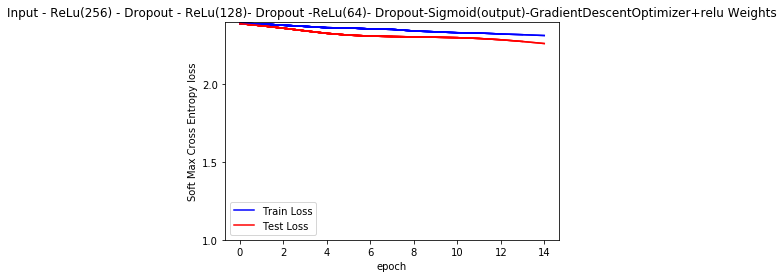

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-GradientDescentOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

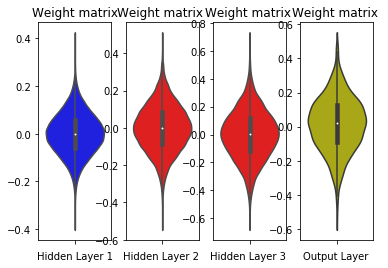

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 4 + AdamOptimizer+sgd Weights __

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.791308308 test cost=1.695390935
Epoch: 0002 train cost=1.591288492 test cost=1.536903056
Epoch: 0003 train cost=1.554282290 test cost=1.513752728
Epoch: 0004 train cost=1.539843777 test cost=1.507338477
Epoch: 0005 train cost=1.531619705 test cost=1.502449374
Epoch: 0006 train cost=1.523564587 test cost=1.499625919
Epoch: 0007 train cost=1.518837786 test cost=1.496875337
Epoch: 0008 train cost=1.517148022 test cost=1.494869371
Epoch: 0009 train cost=1.513375388 test cost=1.492486547
Epoch: 0010 train cost=1.512787102 test cost=1.492655339
Epoch: 0011 train cost=1.509814232 test cost=1.491535208
Epoch: 0012 train cost=1.507120016 test cost=1.490977947
Epoch: 0013 train cost=1.505824508 test cost=1.490282177
Epoch: 0014 train cost=1.505325179 test cost=1.4896402

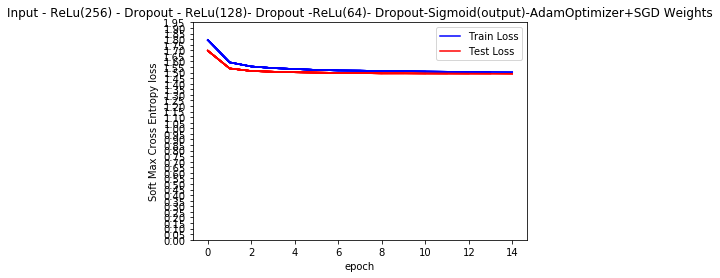

In [0]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-AdamOptimizer+SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-AdamOptimizer +SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

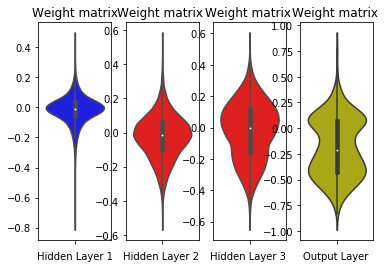

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 4 +  GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.355781506 test cost=2.324307837
Epoch: 0002 train cost=2.352352134 test cost=2.310103058
Epoch: 0003 train cost=2.341589798 test cost=2.298219631
Epoch: 0004 train cost=2.338130634 test cost=2.289050024
Epoch: 0005 train cost=2.331353489 test cost=2.281878536
Epoch: 0006 train cost=2.326082851 test cost=2.276635172
Epoch: 0007 train cost=2.320869718 test cost=2.272188991
Epoch: 0008 train cost=2.319767818 test cost=2.268425871
Epoch: 0009 train cost=2.313789131 test cost=2.264706629
Epoch: 0010 train cost=2.309181134 test cost=2.261119142
Epoch: 0011 train cost=2.304657237 test cost=2.257403255
Epoch: 0012 train cost=2.302508158 test cost=2.253771321
Epoch: 0013 train cost=2.298576075 test cost=2.249780674
Epoch: 0014 train cost=2.295420345 test cost=2.245385662
Epoch: 0015 train cost=2.293383194 test cost=2.240887367
Accuracy: 0.1914


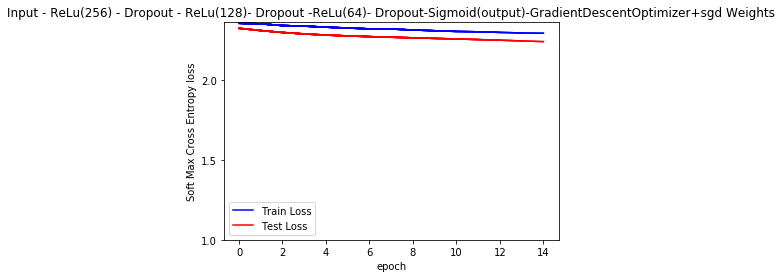

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-GradientDescentOptimizer+sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Sigmoid(output)-GradientDescentOptimizer + wgd Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

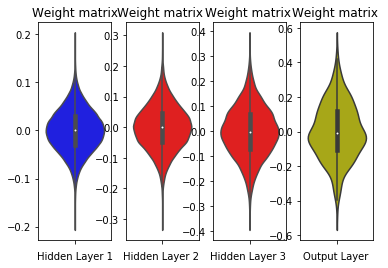

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 5: Input - Relu(BatchNormalization(256)) - Relu(BatchNormalization(128))-Relu(BatchNormalization(64))- Relu(output) 

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Relu activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    	
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Relu activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    ######################################################################################
    
    # Hidden layer with Relu activation and batch normalization
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, beta_3, scale_3, epsilon)
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        
    
    
    # output layer with Relu activation 
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

**Model 5+ AdamOptimizer+relu weights**

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.934476875 test cost=0.896588447
Epoch: 0002 train cost=0.564432422 test cost=0.552748023
Epoch: 0003 train cost=0.527298985 test cost=0.532596968
Epoch: 0004 train cost=0.512796361 test cost=0.524286162
Epoch: 0005 train cost=0.496428138 test cost=0.522662132
Epoch: 0006 train cost=0.495543192 test cost=0.519745046
Epoch: 0007 train cost=0.491851989 test cost=0.520345191
Epoch: 0008 train cost=0.476149432 test cost=0.521556518
Epoch: 0009 train cost=0.489034914 test cost=0.521897881
Epoch: 0010 train cost=0.479896509 test cost=0.521246527
Epoch: 0011 train cost=0.475363789 test cost=0.524298734
Epoch: 0012 train cost=0.485223002 test cost=0.525560694
Epoch: 0013 train cost=0.479055100 test cost=0.526645889
Epoch: 0014 train cost=0.475767938 test cost=0.5291054

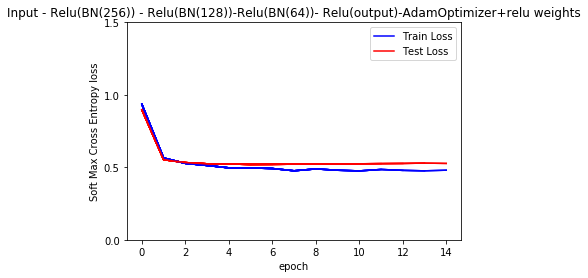

In [0]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-AdamOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


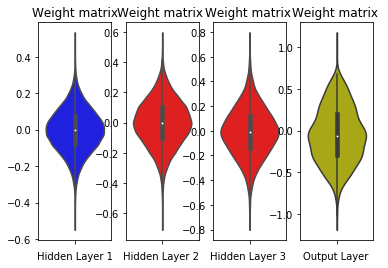

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**__** Model 5 + GradientDescentOptimizer +relu weights  __

Epoch: 0001 train cost=2.217794344 test cost=2.199985033
Epoch: 0002 train cost=1.690580481 test cost=1.660724312
Epoch: 0003 train cost=1.361872445 test cost=1.332300612
Epoch: 0004 train cost=1.163153843 test cost=1.123925379
Epoch: 0005 train cost=1.013184079 test cost=0.980191972
Epoch: 0006 train cost=0.910675027 test cost=0.872708097
Epoch: 0007 train cost=0.823761492 test cost=0.788328006
Epoch: 0008 train cost=0.759451556 test cost=0.720416680
Epoch: 0009 train cost=0.705778281 test cost=0.664860717
Epoch: 0010 train cost=0.656172651 test cost=0.618560617
Epoch: 0011 train cost=0.618223563 test cost=0.579564688
Epoch: 0012 train cost=0.585432936 test cost=0.546261914
Epoch: 0013 train cost=0.549854774 test cost=0.517397301
Epoch: 0014 train cost=0.532648666 test cost=0.492284715
Epoch: 0015 train cost=0.504928621 test cost=0.470016200
Accuracy: 0.8851


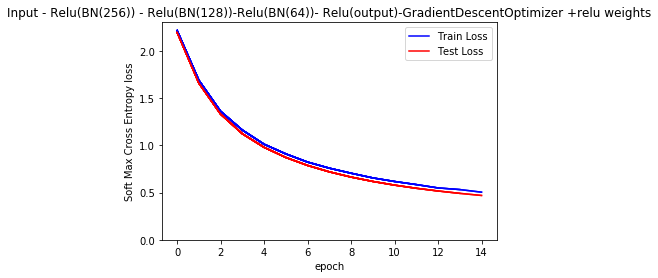

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-GradientDescentOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-GradientDescentOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

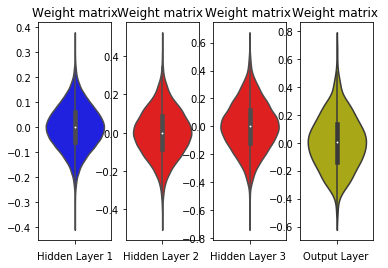

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 5+ AdamOptimizer+sgd weights**

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.329606009 test cost=0.305122825
Epoch: 0002 train cost=0.095048225 test cost=0.096637891
Epoch: 0003 train cost=0.058845351 test cost=0.079821754
Epoch: 0004 train cost=0.041571837 test cost=0.073915051
Epoch: 0005 train cost=0.032436482 test cost=0.072812768
Epoch: 0006 train cost=0.025730786 test cost=0.070778520
Epoch: 0007 train cost=0.022189353 test cost=0.075182003
Epoch: 0008 train cost=0.017023948 test cost=0.074191325
Epoch: 0009 train cost=0.016927786 test cost=0.074627952
Epoch: 0010 train cost=0.016313710 test cost=0.080220343
Epoch: 0011 train cost=0.014214382 test cost=0.079745081
Epoch: 0012 train cost=0.013399972 test cost=0.074221454
Epoch: 0013 train cost=0.010423170 test cost=0.075364084
Epoch: 0014 train cost=0.011661897 test cost=0.0792921

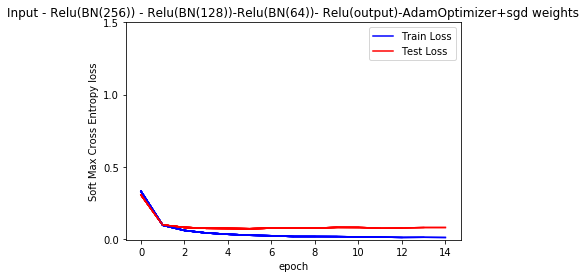

In [0]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-AdamOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


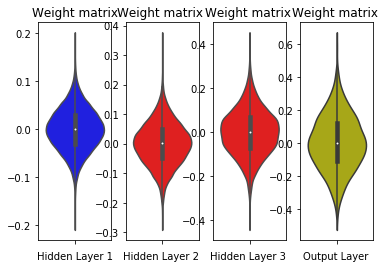

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**__** Model 5 + GradientDescentOptimizer +sgd weights  __

Epoch: 0001 train cost=2.485995891 test cost=2.463073777
Epoch: 0002 train cost=1.959512924 test cost=1.932612779
Epoch: 0003 train cost=1.742557134 test cost=1.706696565
Epoch: 0004 train cost=1.570032622 test cost=1.528945540
Epoch: 0005 train cost=1.424193450 test cost=1.379446144
Epoch: 0006 train cost=1.310757549 test cost=1.263646571
Epoch: 0007 train cost=1.221738973 test cost=1.174544517
Epoch: 0008 train cost=1.136070265 test cost=1.100292574
Epoch: 0009 train cost=1.080094075 test cost=1.029838131
Epoch: 0010 train cost=0.998551914 test cost=0.954227364
Epoch: 0011 train cost=0.929861418 test cost=0.880966810
Epoch: 0012 train cost=0.867758799 test cost=0.821827013
Epoch: 0013 train cost=0.827996119 test cost=0.776675777
Epoch: 0014 train cost=0.784622981 test cost=0.741046611
Epoch: 0015 train cost=0.761842044 test cost=0.711988331
Accuracy: 0.7984


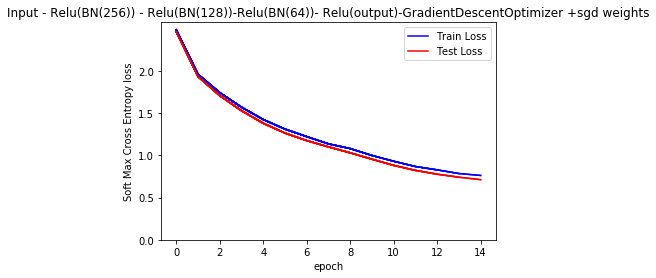

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-GradientDescentOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "Input - Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(output)-GradientDescentOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

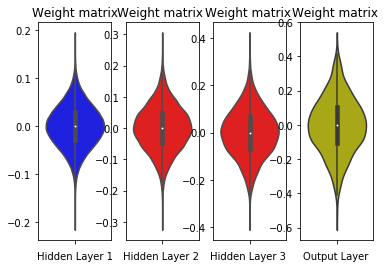

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

***Model 6: Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)***

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2_drop, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_3_drop = tf.nn.dropout(layer_3, rate)
    print( 'layer_3:', layer_3.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b4:', biases['out'].get_shape())        
    
    # Output layer with Relu activation
    out_layer = tf.matmul(layer_3_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 6 + AdamOptimizer+relu weights

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.005535062 test cost=1.685129117
Epoch: 0002 train cost=0.767555614 test cost=0.395525303
Epoch: 0003 train cost=0.480188876 test cost=0.237012863
Epoch: 0004 train cost=0.379786256 test cost=0.195046633
Epoch: 0005 train cost=0.322565607 test cost=0.166674536
Epoch: 0006 train cost=0.280970639 test cost=0.150583008
Epoch: 0007 train cost=0.259315972 test cost=0.140289302
Epoch: 0008 train cost=0.229621540 test cost=0.129831429
Epoch: 0009 train cost=0.216896728 test cost=0.122569227
Epoch: 0010 train cost=0.203116786 test cost=0.117004577
Epoch: 0011 train cost=0.193684949 test cost=0.113202786
Epoch: 0012 train cost=0.182737709 test cost=0.111689231
Epoch: 0013 train cost=0.171656287 test cost=0.110079705
Epoch: 0014 train cost=0.163943670 test cost=0.1080779

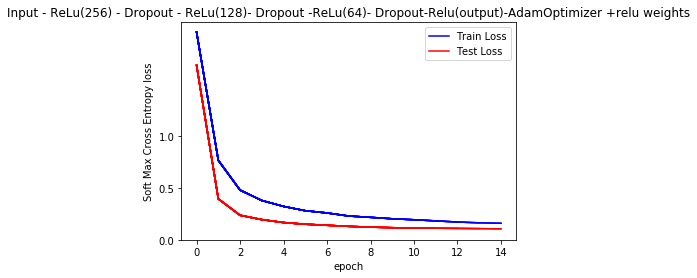

In [0]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-AdamOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-AdamOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

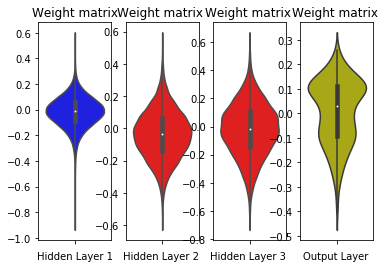

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

![alt text](https://)Model6+ GradientDescentOptimizer+relu weights

Epoch: 0001 train cost=2.361730664 test cost=2.336576071
Epoch: 0002 train cost=2.355352657 test cost=2.326649566
Epoch: 0003 train cost=2.350725438 test cost=2.317003067
Epoch: 0004 train cost=2.341962675 test cost=2.307532917
Epoch: 0005 train cost=2.335036240 test cost=2.297724526
Epoch: 0006 train cost=2.332321518 test cost=2.287629805
Epoch: 0007 train cost=2.328402152 test cost=2.277601956
Epoch: 0008 train cost=2.320511825 test cost=2.268156631
Epoch: 0009 train cost=2.316160900 test cost=2.258981259
Epoch: 0010 train cost=2.310445600 test cost=2.250588324
Epoch: 0011 train cost=2.303629388 test cost=2.242782904
Epoch: 0012 train cost=2.300844158 test cost=2.235376015
Epoch: 0013 train cost=2.294315880 test cost=2.228271552
Epoch: 0014 train cost=2.292119904 test cost=2.220860204
Epoch: 0015 train cost=2.284825244 test cost=2.212586049
Accuracy: 0.4048


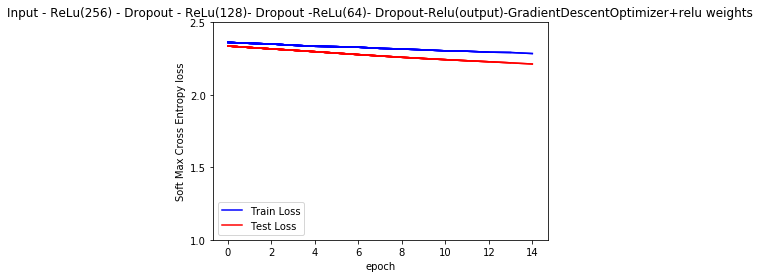

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

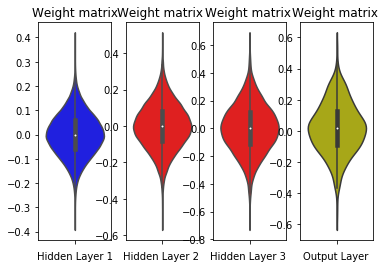

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 6 + AdamOptimizer+sgd weights

x: (?, 784) W[h1]: (784, 256) b[h1]: (256,)
layer_1: (?, 256) W[h2]: (256, 128) b[h2]: (128,)
layer_2: (?, 128) W[h3]: (128, 64) b[h3]: (64,)
layer_3: (?, 64) W[out]: (64, 10) b4: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.145483224 test cost=0.786346289
Epoch: 0002 train cost=0.437969151 test cost=0.228400437
Epoch: 0003 train cost=0.345249134 test cost=0.175326437
Epoch: 0004 train cost=0.285611886 test cost=0.151748890
Epoch: 0005 train cost=0.249619291 test cost=0.137789112
Epoch: 0006 train cost=0.227969138 test cost=0.129079226
Epoch: 0007 train cost=0.211389324 test cost=0.121206002
Epoch: 0008 train cost=0.192354378 test cost=0.113075375
Epoch: 0009 train cost=0.191157123 test cost=0.109007814
Epoch: 0010 train cost=0.179917494 test cost=0.109703937
Epoch: 0011 train cost=0.165488747 test cost=0.104988277
Epoch: 0012 train cost=0.164738355 test cost=0.104411634
Epoch: 0013 train cost=0.154594013 test cost=0.102792115
Epoch: 0014 train cost=0.150288253 test cost=0.0998760

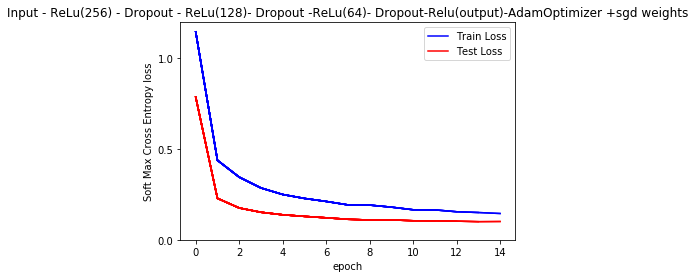

In [0]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-AdamOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

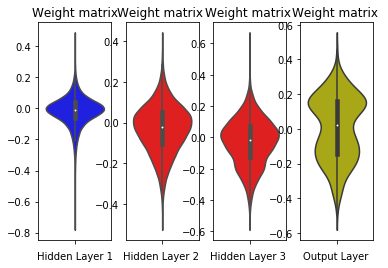

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model6+ GradientDescentOptimizer+sgd weights

Epoch: 0001 train cost=2.685033643 test cost=2.319990298
Epoch: 0002 train cost=2.381452577 test cost=2.302585602
Epoch: 0003 train cost=2.342420947 test cost=2.302585602
Epoch: 0004 train cost=2.330745661 test cost=2.302585602
Epoch: 0005 train cost=2.320991811 test cost=2.302585602
Epoch: 0006 train cost=2.316815849 test cost=2.302585602
Epoch: 0007 train cost=2.314943762 test cost=2.302585602
Epoch: 0008 train cost=2.312542552 test cost=2.302585602
Epoch: 0009 train cost=2.310792181 test cost=2.302585602
Epoch: 0010 train cost=2.310895278 test cost=2.302585602
Epoch: 0011 train cost=2.308196544 test cost=2.302585602
Epoch: 0012 train cost=2.308119274 test cost=2.302585602
Epoch: 0013 train cost=2.307607978 test cost=2.302585602
Epoch: 0014 train cost=2.306634240 test cost=2.302585602
Epoch: 0015 train cost=2.306138869 test cost=2.302585602
Accuracy: 0.098


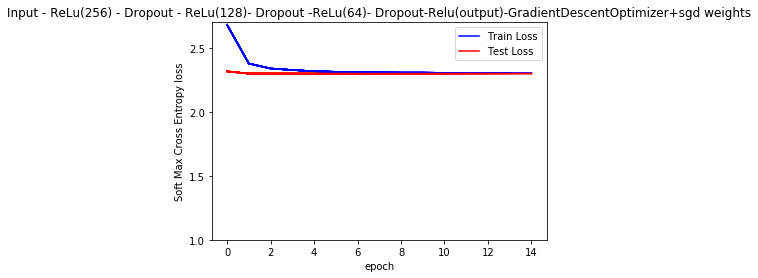

In [0]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

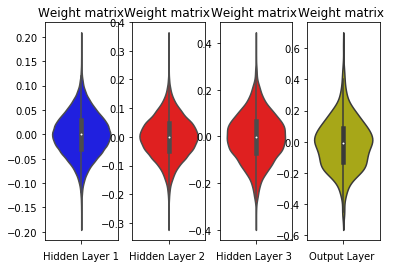

In [0]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 4, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 4, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3>Architecture 3: 784-512-256-128-64-32-10</h3>

In [0]:
# Network Parameters

n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons
n_hidden_4 = 64 # 4th layer number of neurons
n_hidden_5 = 32 # 5th layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [0]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [0]:
# Weight initialization

weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.051, mean=0)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.072, mean=0)),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4],stddev=0.102, mean=0)),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5],stddev=0.144, mean=0)),
    'out': tf.Variable(tf.random_normal([n_hidden_5, n_classes],stddev=0.218, mean=0))
}

weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.088, mean=0)),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3],stddev=0.125, mean=0)),
    'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4],stddev=0.175, mean=0)),
    'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5],stddev=0.246, mean=0)),
    'out': tf.Variable(tf.random_normal([n_hidden_5, n_classes],stddev=0.215, mean=0))  
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'b5': tf.Variable(tf.random_normal([n_hidden_5])),
    'out': tf.Variable(tf.random_normal([n_classes]))              
}

In [0]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

<h3> Model 1: input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h2'].get_shape(), 'b[h3]:', biases['b3'].get_shape())

    # Hidden layer with Sigmoid activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape())        

    # Hidden layer with Sigmoid activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_4 = tf.nn.sigmoid(layer_4)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())

    # Hidden layer with Sigmoid activation
    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_5 = tf.nn.sigmoid(layer_5)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        

    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_5, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer with SGD Weight__

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (512, 256) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.960491954 test cost=1.960044774
Epoch: 0002 train cost=1.779930746 test cost=1.782137749
Epoch: 0003 train cost=1.730137728 test cost=1.733345582
Epoch: 0004 train cost=1.699029118 test cost=1.701609386
Epoch: 0005 train cost=1.685450684 test cost=1.688391165
Epoch: 0006 train cost=1.636204370 test cost=1.639543891
Epoch: 0007 train cost=1.618657986 test cost=1.622774642
Epoch: 0008 train cost=1.597445394 test cost=1.601033726
Epoch: 0009 train cost=1.590469628 test cost=1.594963344
Epoch: 0010 train cost=1.585868853 test cost=1.592370189
Epoch: 0011 train cost=1.583677219 test cost=1.590296917
Epoch: 0012 train cost=1.575698884 test cost=1.583325798
Epoch: 0013 tra

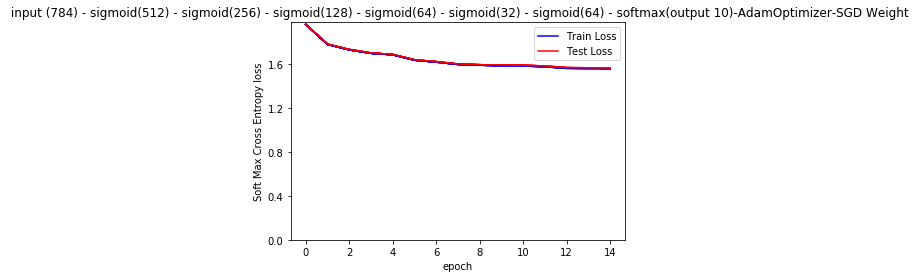

In [11]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_sgd, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-AdamOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-AdamOptimizer-SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

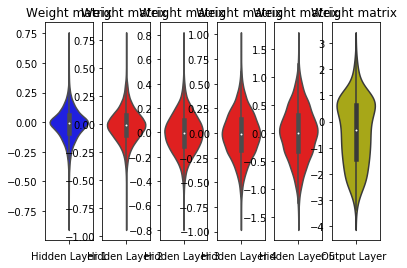

In [12]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with SGD Weight__

Epoch: 0001 train cost=2.333839350 test cost=2.331015015
Epoch: 0002 train cost=2.332881111 test cost=2.330085717
Epoch: 0003 train cost=2.331942675 test cost=2.329183701
Epoch: 0004 train cost=2.331025178 test cost=2.328298909
Epoch: 0005 train cost=2.330130156 test cost=2.327424564
Epoch: 0006 train cost=2.329258533 test cost=2.326576675
Epoch: 0007 train cost=2.328410814 test cost=2.325763448
Epoch: 0008 train cost=2.327587358 test cost=2.324960282
Epoch: 0009 train cost=2.326788309 test cost=2.324202285
Epoch: 0010 train cost=2.326013735 test cost=2.323458580
Epoch: 0011 train cost=2.325263549 test cost=2.322737634
Epoch: 0012 train cost=2.324537568 test cost=2.322039692
Epoch: 0013 train cost=2.323835056 test cost=2.321377185
Epoch: 0014 train cost=2.323155797 test cost=2.320721029
Epoch: 0015 train cost=2.322499360 test cost=2.320098866
Accuracy: 0.1009


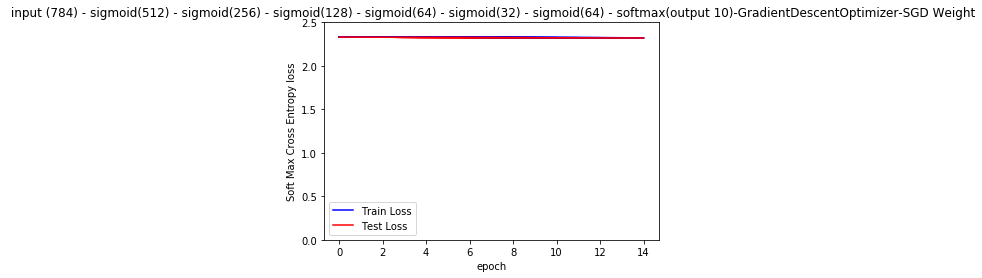

In [13]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-GradientDescentOptimizer-SGD Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-GradientDescentOptimizer- SGD Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

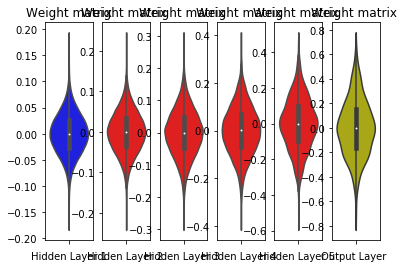

In [14]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + AdamOptimizer with Relu Weight__

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (512, 256) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.869202719 test cost=1.866007467
Epoch: 0002 train cost=1.594145730 test cost=1.594205003
Epoch: 0003 train cost=1.543323746 test cost=1.545236231
Epoch: 0004 train cost=1.522913632 test cost=1.527070315
Epoch: 0005 train cost=1.510177385 test cost=1.515174290
Epoch: 0006 train cost=1.495974150 test cost=1.501237541
Epoch: 0007 train cost=1.489429997 test cost=1.496350781
Epoch: 0008 train cost=1.485496908 test cost=1.492222050
Epoch: 0009 train cost=1.481803734 test cost=1.489985235
Epoch: 0010 train cost=1.479518924 test cost=1.489206630
Epoch: 0011 train cost=1.477896512 test cost=1.487843795
Epoch: 0012 train cost=1.476098161 test cost=1.486430652
Epoch: 0013 tra

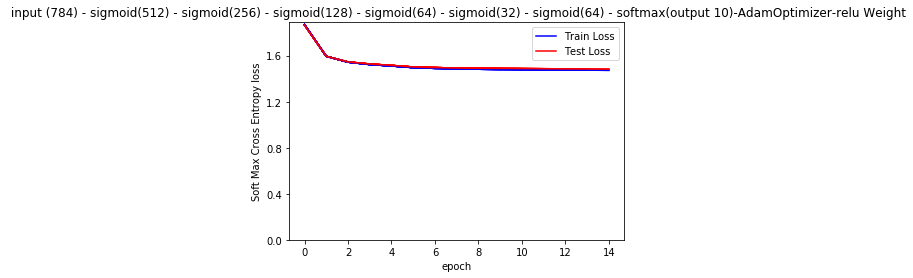

In [15]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_relu = multilayer_perceptron(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_relu, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-AdamOptimizer-relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-AdamOptimizer-relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

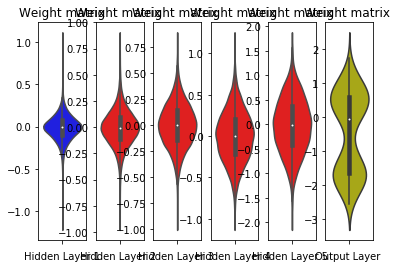

In [16]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer with relu Weight__

Epoch: 0001 train cost=2.319677201 test cost=2.318645258
Epoch: 0002 train cost=2.319200845 test cost=2.318149092
Epoch: 0003 train cost=2.318739779 test cost=2.317665010
Epoch: 0004 train cost=2.318294464 test cost=2.317206200
Epoch: 0005 train cost=2.317864568 test cost=2.316753128
Epoch: 0006 train cost=2.317449642 test cost=2.316331824
Epoch: 0007 train cost=2.317049665 test cost=2.315919792
Epoch: 0008 train cost=2.316664431 test cost=2.315515469
Epoch: 0009 train cost=2.316293738 test cost=2.315136397
Epoch: 0010 train cost=2.315937017 test cost=2.314759915
Epoch: 0011 train cost=2.315594142 test cost=2.314407077
Epoch: 0012 train cost=2.315264683 test cost=2.314061672
Epoch: 0013 train cost=2.314947770 test cost=2.313741850
Epoch: 0014 train cost=2.314643266 test cost=2.313423959
Epoch: 0015 train cost=2.314350670 test cost=2.313122115
Accuracy: 0.1135


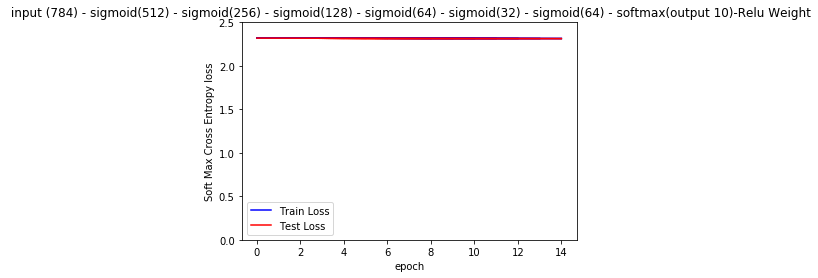

In [17]:

optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-Relu Weight")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 3, step=0.5), " input (784) - sigmoid(512) - sigmoid(256) - sigmoid(128) - sigmoid(64) - sigmoid(32) - sigmoid(64) - softmax(output 10)-Relu Weight")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

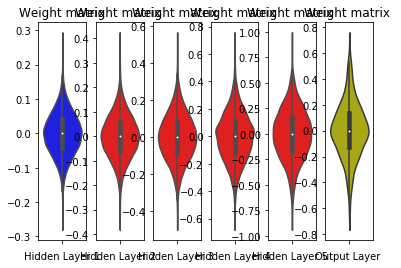

In [18]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        

    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape())

    # Hidden layer with ReLu activation
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_4 = tf.nn.relu(layer_4)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())

    # Hidden layer with ReLu activation
    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_5 = tf.nn.relu(layer_5)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        

    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_5, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 2 + AdamOptimizer + Relu Weights  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.599495009 test cost=1.592884100
Epoch: 0002 train cost=1.499761097 test cost=1.499673021
Epoch: 0003 train cost=1.489772229 test cost=1.491732673
Epoch: 0004 train cost=1.483888368 test cost=1.488085620
Epoch: 0005 train cost=1.481536874 test cost=1.486883594
Epoch: 0006 train cost=1.479799600 test cost=1.485009353
Epoch: 0007 train cost=1.477128399 test cost=1.483803006
Epoch: 0008 train cost=1.476639228 test cost=1.483132327
Epoch: 0009 train cost=1.476015543 test cost=1.482498119
Epoch: 0010 train cost=1.475835420 test cost=1.482436678
Epoch: 0011 train cost=1.476057929 test cost=1.483805839
Epoch: 0012 train cost=1.474202270 test cost=1.482477783
Epoch: 0013 tra

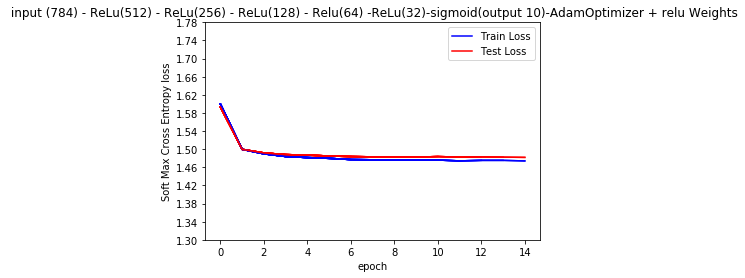

In [21]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-AdamOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-AdamOptimizer + relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

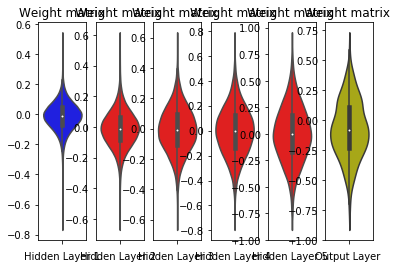

In [22]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model2- GradientDescentOptimizer +relu Weights__

Epoch: 0001 train cost=2.264000041 test cost=2.264715878
Epoch: 0002 train cost=2.102049611 test cost=2.099468035
Epoch: 0003 train cost=1.987929187 test cost=1.982917305
Epoch: 0004 train cost=1.917481399 test cost=1.910918606
Epoch: 0005 train cost=1.873996983 test cost=1.867010405
Epoch: 0006 train cost=1.843852326 test cost=1.836809626
Epoch: 0007 train cost=1.820621347 test cost=1.813521293
Epoch: 0008 train cost=1.801284759 test cost=1.794077280
Epoch: 0009 train cost=1.774061669 test cost=1.766923537
Epoch: 0010 train cost=1.723551107 test cost=1.716394965
Epoch: 0011 train cost=1.698623078 test cost=1.690956116
Epoch: 0012 train cost=1.681746386 test cost=1.674087558
Epoch: 0013 train cost=1.669088003 test cost=1.661513156
Epoch: 0014 train cost=1.658982342 test cost=1.651440908
Epoch: 0015 train cost=1.650563167 test cost=1.643194671
Accuracy: 0.8384


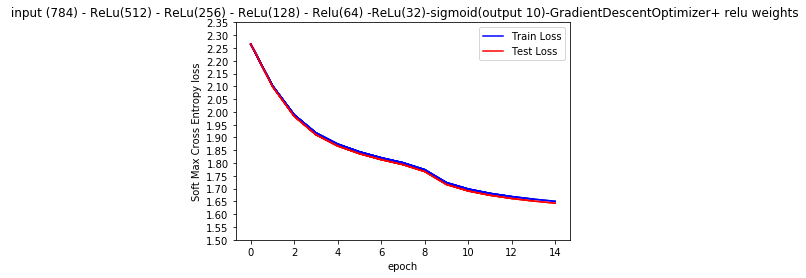

In [23]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-GradientDescentOptimizer+ relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

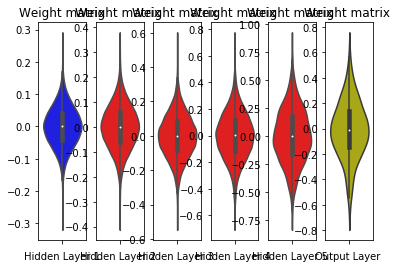

In [24]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 2 + AdamOptimizer + sgd Weights  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.584768544 test cost=1.579261650
Epoch: 0002 train cost=1.501716514 test cost=1.501239397
Epoch: 0003 train cost=1.489365720 test cost=1.491391562
Epoch: 0004 train cost=1.483720877 test cost=1.486752527
Epoch: 0005 train cost=1.480339132 test cost=1.484977405
Epoch: 0006 train cost=1.477185538 test cost=1.483404095
Epoch: 0007 train cost=1.475892869 test cost=1.482672600
Epoch: 0008 train cost=1.474398999 test cost=1.482266278
Epoch: 0009 train cost=1.472791532 test cost=1.481132742
Epoch: 0010 train cost=1.474054451 test cost=1.482713123
Epoch: 0011 train cost=1.472799192 test cost=1.481923764
Epoch: 0012 train cost=1.473430540 test cost=1.482456488
Epoch: 0013 tra

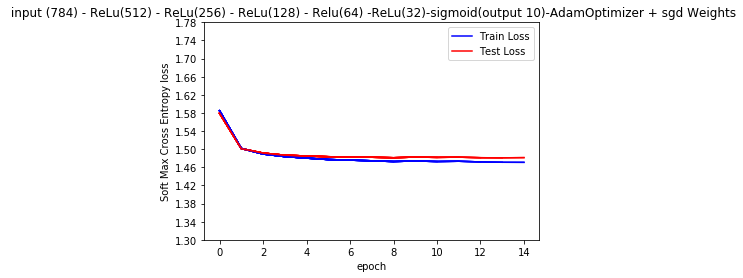

In [25]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ysgd = multilayer_perceptron_relu(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ysgd, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-AdamOptimizer + sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-AdamOptimizer + sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

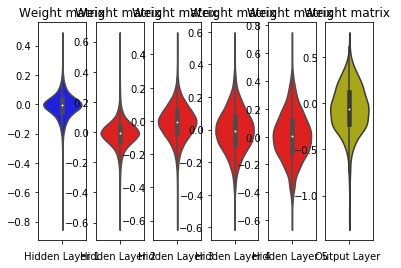

In [26]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Model2 - GradientDescentOptimizer +sgd Weights__

Epoch: 0001 train cost=2.328852736 test cost=2.329820057
Epoch: 0002 train cost=2.309755380 test cost=2.310395604
Epoch: 0003 train cost=2.296985160 test cost=2.297140838
Epoch: 0004 train cost=2.283136647 test cost=2.282815736
Epoch: 0005 train cost=2.268270186 test cost=2.267308086
Epoch: 0006 train cost=2.251201962 test cost=2.249489637
Epoch: 0007 train cost=2.231186435 test cost=2.228701895
Epoch: 0008 train cost=2.207556974 test cost=2.204324714
Epoch: 0009 train cost=2.177608118 test cost=2.173334908
Epoch: 0010 train cost=2.143506256 test cost=2.138394787
Epoch: 0011 train cost=2.106920715 test cost=2.100929386
Epoch: 0012 train cost=2.067921348 test cost=2.061203783
Epoch: 0013 train cost=2.027621926 test cost=2.020084019
Epoch: 0014 train cost=1.987867294 test cost=1.979906518
Epoch: 0015 train cost=1.953850230 test cost=1.945526648
Accuracy: 0.6388


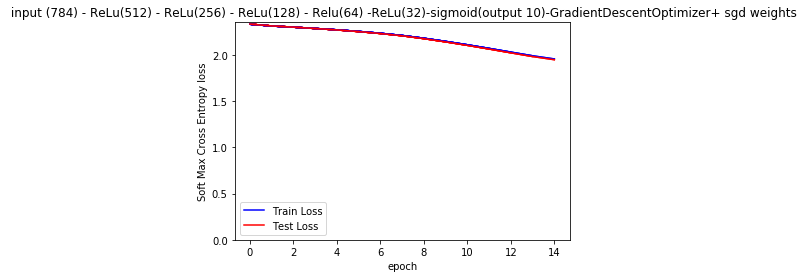

In [27]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-GradientDescentOptimizer+ sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), " input (784) - ReLu(512) - ReLu(256) - ReLu(128) - Relu(64) -ReLu(32)-sigmoid(output 10)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ysgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

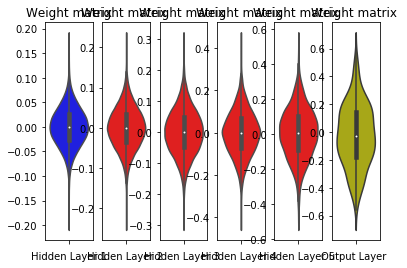

In [28]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(512))-Sigmoid(BatchNormalization(256)) - Sigmoid(BatchNormalization(128))-Sigmoid(BatchNormalization(64))- Sigmoid(BatchNormalization(32))-Sigmoid(output) </h3>

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    ######################################################################################

    # Hidden layer with Sigmoid activation and batch normalization
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, beta_3, scale_3, epsilon)
    layer_3 = tf.nn.sigmoid(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape()) 

    # Hidden layer with Sigmoid activation and batch normalization
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_4, batch_var_4 = tf.nn.moments(layer_4, [0])
    
    scale_4 = tf.Variable(tf.ones([n_hidden_4]))
    beta_4 = tf.Variable(tf.zeros([n_hidden_4]))
    
    layer_4 = tf.nn.batch_normalization(layer_4, batch_mean_4, batch_var_4, beta_4, scale_4, epsilon)
    layer_4 = tf.nn.sigmoid(layer_4)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())        

    # Hidden layer with Sigmoid activation and batch normalization
    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_5, batch_var_5 = tf.nn.moments(layer_5, [0])
    
    scale_5 = tf.Variable(tf.ones([n_hidden_5]))
    beta_5 = tf.Variable(tf.zeros([n_hidden_5]))
    
    layer_5 = tf.nn.batch_normalization(layer_5, batch_mean_5, batch_var_5, beta_5, scale_5, epsilon)
    layer_5 = tf.nn.sigmoid(layer_5)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        
    
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_5, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer+SGD Weights  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.855443731 test cost=1.847892092
Epoch: 0002 train cost=1.604222132 test cost=1.598415934
Epoch: 0003 train cost=1.534805991 test cost=1.532682663
Epoch: 0004 train cost=1.508728858 test cost=1.509143004
Epoch: 0005 train cost=1.496929370 test cost=1.498128412
Epoch: 0006 train cost=1.488967056 test cost=1.491844618
Epoch: 0007 train cost=1.483275637 test cost=1.488311855
Epoch: 0008 train cost=1.480422675 test cost=1.486319611
Epoch: 0009 train cost=1.477710648 test cost=1.484647880
Epoch: 0010 train cost=1.475828750 test cost=1.483388537
Epoch: 0011 train cost=1.474019744 test cost=1.482126320
Epoch: 0012 train cost=1.472513873 test cost=1.482047863
Epoch: 0013 tra

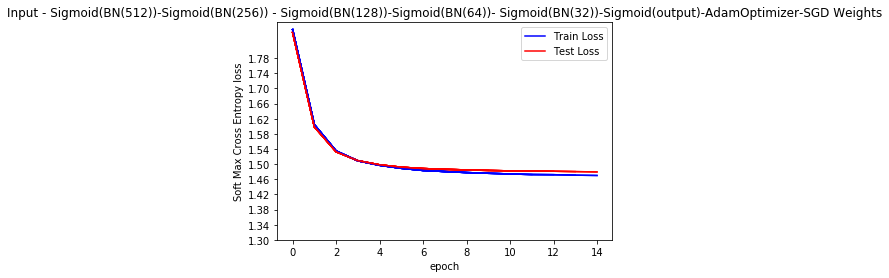

In [30]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

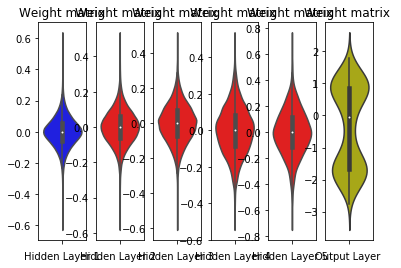

In [31]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.318445943 test cost=2.320035968
Epoch: 0002 train cost=2.291683291 test cost=2.292390313
Epoch: 0003 train cost=2.272087691 test cost=2.272336573
Epoch: 0004 train cost=2.257104631 test cost=2.256982865
Epoch: 0005 train cost=2.244812681 test cost=2.244482812
Epoch: 0006 train cost=2.234324793 test cost=2.233781999
Epoch: 0007 train cost=2.224986219 test cost=2.224210164
Epoch: 0008 train cost=2.216295476 test cost=2.215497330
Epoch: 0009 train cost=2.208441246 test cost=2.207367433
Epoch: 0010 train cost=2.200975112 test cost=2.199703675
Epoch: 0011 train cost=2.193737415 test cost=2.192411312
Epoch: 0012 train cost=2.186991629 test cost=2.185432588
Epoch: 0013 train cost=2.180442709 test cost=2.178728245
Epoch: 0014 train cost=2.174062219 test cost=2.172231989
Epoch: 0015 train cost=2.167931615 test cost=2.165963620
Accuracy: 0.438


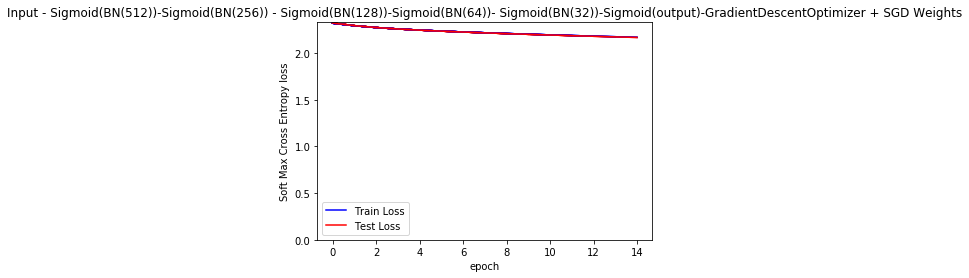

In [32]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-GradientDescentOptimizer + SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

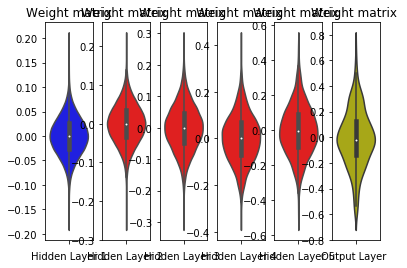

In [33]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3+ AdamOptimizer+Relu Weights  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.872665866 test cost=1.865724442
Epoch: 0002 train cost=1.605219549 test cost=1.600030769
Epoch: 0003 train cost=1.535029329 test cost=1.533138143
Epoch: 0004 train cost=1.509253064 test cost=1.509599926
Epoch: 0005 train cost=1.496331415 test cost=1.498750544
Epoch: 0006 train cost=1.488570391 test cost=1.492785965
Epoch: 0007 train cost=1.483524790 test cost=1.488994191
Epoch: 0008 train cost=1.480058387 test cost=1.486485890
Epoch: 0009 train cost=1.477164116 test cost=1.484383796
Epoch: 0010 train cost=1.474844484 test cost=1.483150421
Epoch: 0011 train cost=1.472984434 test cost=1.482122039
Epoch: 0012 train cost=1.471366532 test cost=1.481476919
Epoch: 0013 tra

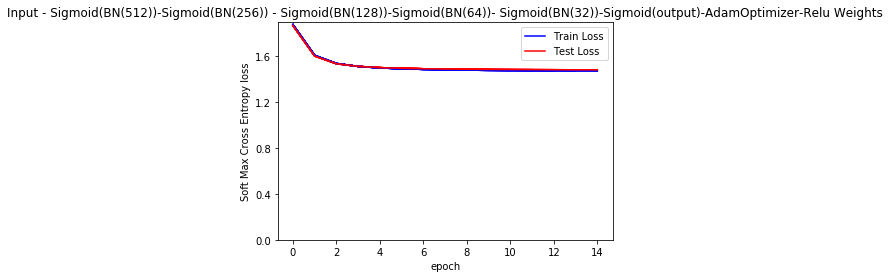

In [34]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-Relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.4), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-Relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

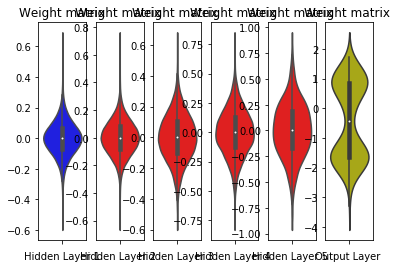

In [35]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer +Relu Weights __

Epoch: 0001 train cost=2.330143619 test cost=2.330428136
Epoch: 0002 train cost=2.314289990 test cost=2.314097767
Epoch: 0003 train cost=2.300437725 test cost=2.299864182
Epoch: 0004 train cost=2.288127630 test cost=2.287347934
Epoch: 0005 train cost=2.277239302 test cost=2.276238265
Epoch: 0006 train cost=2.267502333 test cost=2.266177192
Epoch: 0007 train cost=2.258427809 test cost=2.256924637
Epoch: 0008 train cost=2.249925374 test cost=2.248356378
Epoch: 0009 train cost=2.242052419 test cost=2.240328527
Epoch: 0010 train cost=2.234526405 test cost=2.232776043
Epoch: 0011 train cost=2.227634351 test cost=2.225672726
Epoch: 0012 train cost=2.221083715 test cost=2.218947929
Epoch: 0013 train cost=2.214691355 test cost=2.212571632
Epoch: 0014 train cost=2.208743190 test cost=2.206458426
Epoch: 0015 train cost=2.203083556 test cost=2.200618078
Accuracy: 0.0974


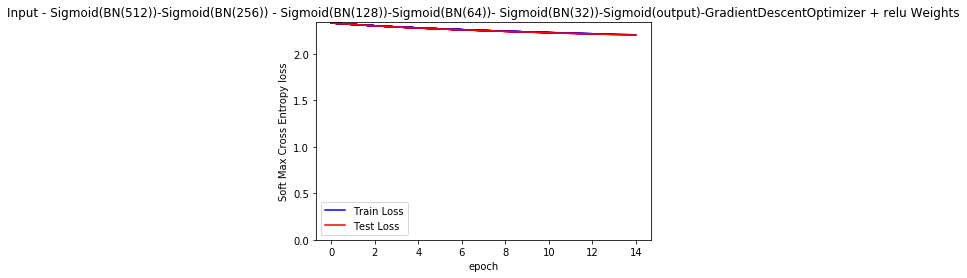

In [36]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.4, step=0.5), "Input - Sigmoid(BN(512))-Sigmoid(BN(256)) - Sigmoid(BN(128))-Sigmoid(BN(64))- Sigmoid(BN(32))-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

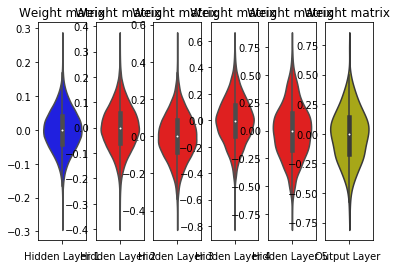

In [37]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output) </h3>

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        

    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2_drop, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_3_drop = tf.nn.dropout(layer_3, rate)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape())        

    
    # Hidden layer with ReLu activation
    layer_4 = tf.add(tf.matmul(layer_3_drop, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_4 = tf.nn.relu(layer_4)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_4_drop = tf.nn.dropout(layer_4, rate)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())        


    # Hidden layer with ReLu activation
    layer_5 = tf.add(tf.matmul(layer_4_drop, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_5 = tf.nn.relu(layer_5)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_5_drop = tf.nn.dropout(layer_5, rate)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        


    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_5_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer+relu Weights __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.365884541 test cost=2.285395206
Epoch: 0002 train cost=2.181504503 test cost=2.081647802
Epoch: 0003 train cost=2.033804961 test cost=1.984317703
Epoch: 0004 train cost=1.967645704 test cost=1.919460246
Epoch: 0005 train cost=1.936939119 test cost=1.894947726
Epoch: 0006 train cost=1.914222038 test cost=1.886078564
Epoch: 0007 train cost=1.904805567 test cost=1.887197497
Epoch: 0008 train cost=1.880684494 test cost=1.855187467
Epoch: 0009 train cost=1.848851811 test cost=1.810214531
Epoch: 0010 train cost=1.839209171 test cost=1.811830171
Epoch: 0011 tr

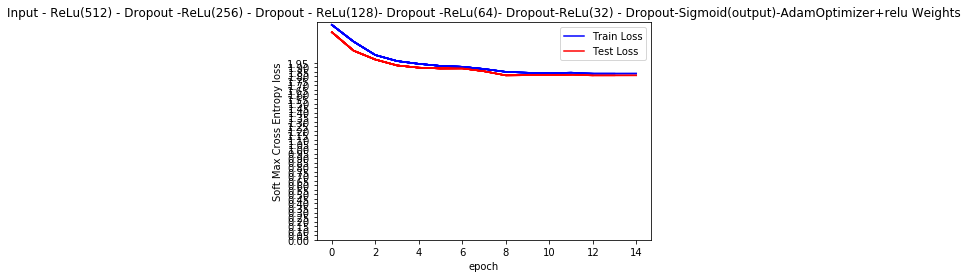

In [39]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-AdamOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-AdamOptimizer +relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

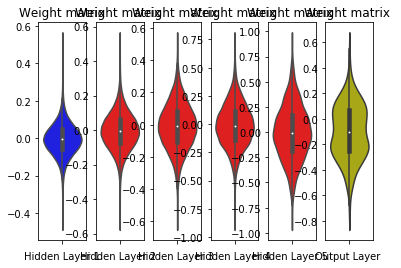

In [40]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 4 +  GradientDescentOptimizer +relu Weights __

Epoch: 0001 train cost=2.395131662 test cost=2.375100322
Epoch: 0002 train cost=2.392391735 test cost=2.374156585
Epoch: 0003 train cost=2.395790467 test cost=2.372765906
Epoch: 0004 train cost=2.392814926 test cost=2.370903448
Epoch: 0005 train cost=2.389331799 test cost=2.364839820
Epoch: 0006 train cost=2.394143517 test cost=2.360340461
Epoch: 0007 train cost=2.389750923 test cost=2.357132828
Epoch: 0008 train cost=2.388942116 test cost=2.351408187
Epoch: 0009 train cost=2.390427540 test cost=2.345150361
Epoch: 0010 train cost=2.387070972 test cost=2.342850194
Epoch: 0011 train cost=2.385983644 test cost=2.339863983
Epoch: 0012 train cost=2.386724198 test cost=2.335064399
Epoch: 0013 train cost=2.382138541 test cost=2.330192135
Epoch: 0014 train cost=2.383099520 test cost=2.326297324
Epoch: 0015 train cost=2.378277187 test cost=2.320397481
Accuracy: 0.1056


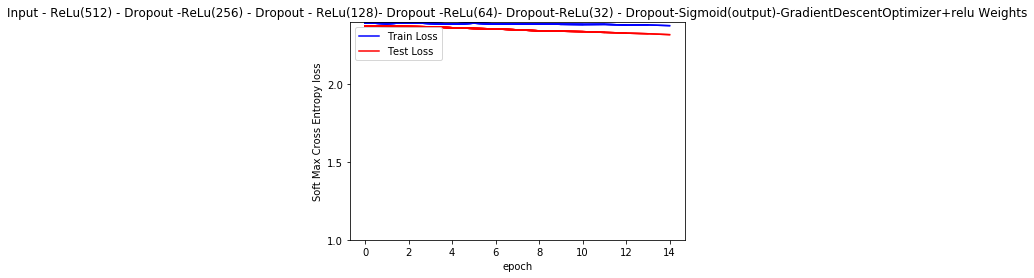

In [41]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-GradientDescentOptimizer+relu Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-GradientDescentOptimizer + relu Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

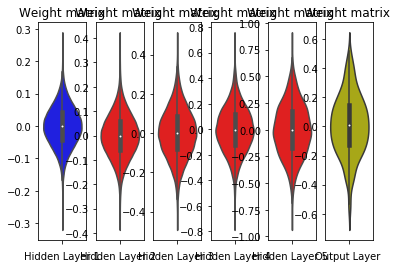

In [42]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 4 + AdamOptimizer+sgd Weights __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.043083519 test cost=1.976326974
Epoch: 0002 train cost=1.829870065 test cost=1.811331898
Epoch: 0003 train cost=1.819227136 test cost=1.807723423
Epoch: 0004 train cost=1.816804957 test cost=1.805442648
Epoch: 0005 train cost=1.797822591 test cost=1.779758284
Epoch: 0006 train cost=1.783413121 test cost=1.769576290
Epoch: 0007 train cost=1.774348490 test cost=1.752015500
Epoch: 0008 train cost=1.745473714 test cost=1.726114676
Epoch: 0009 train cost=1.741759065 test cost=1.723781279
Epoch: 0010 train cost=1.737475320 test cost=1.723624402
Epoch: 0011 train cost=1.737113921 test cost=1.722689913
Epoch: 0012 train cost=1.736986290 test cost=1.722684123
Epoch: 0013 tra

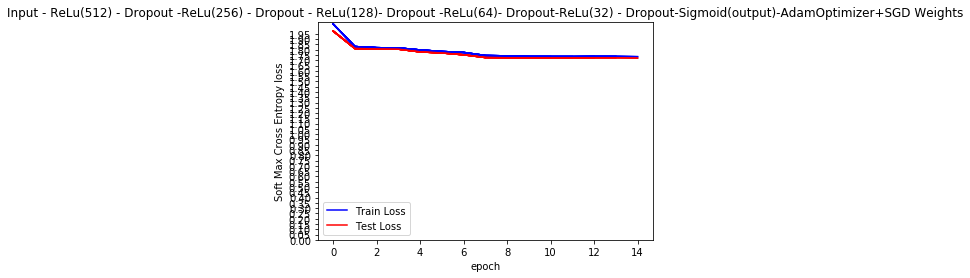

In [43]:
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-AdamOptimizer+SGD Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2, step=0.05), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-AdamOptimizer +SGD Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

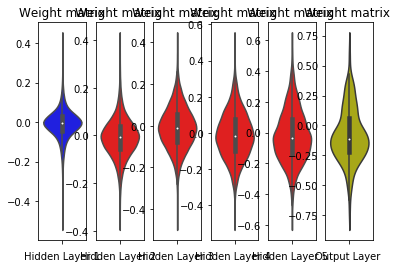

In [44]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 4 +  GradientDescentOptimizer +SGD Weights __

Epoch: 0001 train cost=2.365435973 test cost=2.342137530
Epoch: 0002 train cost=2.365820837 test cost=2.339676104
Epoch: 0003 train cost=2.361513855 test cost=2.338147735
Epoch: 0004 train cost=2.356657944 test cost=2.336836658
Epoch: 0005 train cost=2.358234239 test cost=2.335155183
Epoch: 0006 train cost=2.355333149 test cost=2.333660624
Epoch: 0007 train cost=2.352872038 test cost=2.332391867
Epoch: 0008 train cost=2.352640576 test cost=2.331613606
Epoch: 0009 train cost=2.350719110 test cost=2.331130916
Epoch: 0010 train cost=2.348832406 test cost=2.330761713
Epoch: 0011 train cost=2.344711744 test cost=2.330519845
Epoch: 0012 train cost=2.345012938 test cost=2.330010108
Epoch: 0013 train cost=2.344221485 test cost=2.329682788
Epoch: 0014 train cost=2.343713741 test cost=2.329303229
Epoch: 0015 train cost=2.340579482 test cost=2.329040442
Accuracy: 0.0785


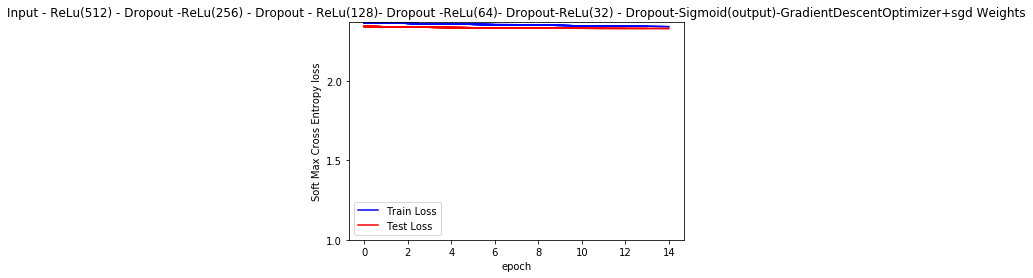

In [45]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-GradientDescentOptimizer+sgd Weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 2.5, step=0.5), "Input - ReLu(512) - Dropout -ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Sigmoid(output)-GradientDescentOptimizer + wgd Weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

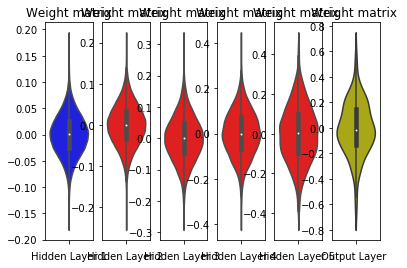

In [46]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 5: Input - Relu(BatchNormalization(512))-Relu(BatchNormalization(256)) - Relu(BatchNormalization(128))-Relu(BatchNormalization(64))-Relu(BatchNormalization(32))- Relu(output) 

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Relu activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    	
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.relu(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Relu activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    ######################################################################################
    
    # Hidden layer with Relu activation and batch normalization
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_3, batch_var_3 = tf.nn.moments(layer_3, [0])
    
    scale_3 = tf.Variable(tf.ones([n_hidden_3]))
    beta_3 = tf.Variable(tf.zeros([n_hidden_3]))
    
    layer_3 = tf.nn.batch_normalization(layer_3, batch_mean_3, batch_var_3, beta_3, scale_3, epsilon)
    layer_3 = tf.nn.relu(layer_3)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape())        
    
    
    # Hidden layer with Relu activation and batch normalization
    layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_4, batch_var_4 = tf.nn.moments(layer_4, [0])
    
    scale_4 = tf.Variable(tf.ones([n_hidden_4]))
    beta_4 = tf.Variable(tf.zeros([n_hidden_4]))
    
    layer_4 = tf.nn.batch_normalization(layer_4, batch_mean_4, batch_var_4, beta_4, scale_4, epsilon)
    layer_4 = tf.nn.relu(layer_4)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())        
    
    # Hidden layer with Relu activation and batch normalization
    layer_5 = tf.add(tf.matmul(layer_4, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_5, batch_var_5 = tf.nn.moments(layer_5, [0])
    
    scale_5 = tf.Variable(tf.ones([n_hidden_5]))
    beta_5 = tf.Variable(tf.zeros([n_hidden_5]))
    
    layer_5 = tf.nn.batch_normalization(layer_5, batch_mean_5, batch_var_5, beta_5, scale_5, epsilon)
    layer_5 = tf.nn.relu(layer_5)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        
    
    
    # output layer with Relu activation 
    out_layer = tf.matmul(layer_5, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

**Model 5+ AdamOptimizer+relu weights**

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.373872603 test cost=0.331292059
Epoch: 0002 train cost=0.095173407 test cost=0.093090975
Epoch: 0003 train cost=0.064003760 test cost=0.077976471
Epoch: 0004 train cost=0.047668776 test cost=0.073587729
Epoch: 0005 train cost=0.039195184 test cost=0.072195218
Epoch: 0006 train cost=0.034876725 test cost=0.070408697
Epoch: 0007 train cost=0.026847551 test cost=0.070431387
Epoch: 0008 train cost=0.023527904 test cost=0.072174552
Epoch: 0009 train cost=0.019343427 test cost=0.069412124
Epoch: 0010 train cost=0.021486788 test cost=0.072685049
Epoch: 0011 train cost=0.020619542 test cost=0.075432805
Epoch: 0012 train cost=0.016915070 test cost=0.072928980
Epoch: 0013 tra

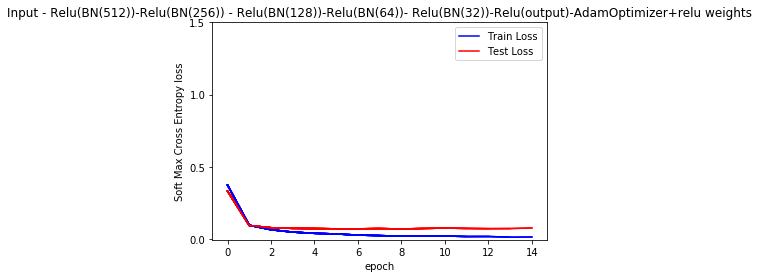

In [48]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-AdamOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


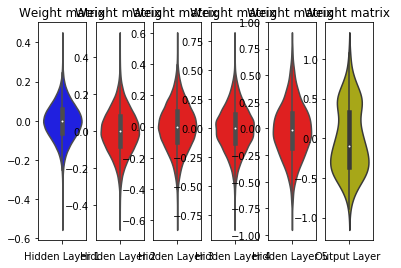

In [49]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**__** Model 5 + GradientDescentOptimizer +relu weights  __

Epoch: 0001 train cost=2.392675346 test cost=2.392887499
Epoch: 0002 train cost=1.983167564 test cost=1.972101769
Epoch: 0003 train cost=1.683197360 test cost=1.664820548
Epoch: 0004 train cost=1.458262920 test cost=1.436677372
Epoch: 0005 train cost=1.293193290 test cost=1.266788545
Epoch: 0006 train cost=1.164902327 test cost=1.134922943
Epoch: 0007 train cost=1.064442274 test cost=1.030489738
Epoch: 0008 train cost=0.979312105 test cost=0.946280143
Epoch: 0009 train cost=0.914178850 test cost=0.877306915
Epoch: 0010 train cost=0.853569064 test cost=0.820169424
Epoch: 0011 train cost=0.806661986 test cost=0.772514768
Epoch: 0012 train cost=0.769416822 test cost=0.732772387
Epoch: 0013 train cost=0.732912186 test cost=0.698927067
Epoch: 0014 train cost=0.700772342 test cost=0.669936768
Epoch: 0015 train cost=0.676016066 test cost=0.644979090
Accuracy: 0.8298


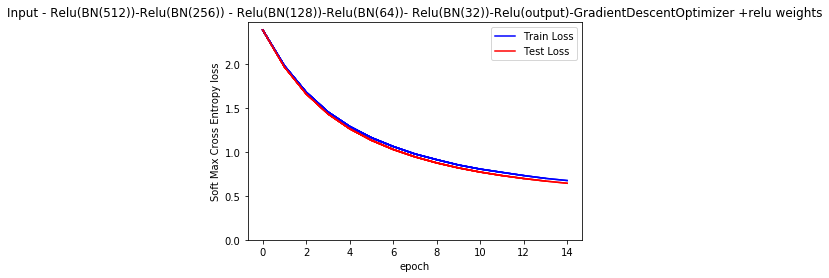

In [50]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-GradientDescentOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-GradientDescentOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

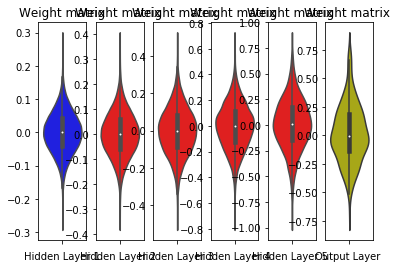

In [51]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**Model 5+ AdamOptimizer+sgd weights**

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=0.739113405 test cost=0.713346050
Epoch: 0002 train cost=0.550535360 test cost=0.551400672
Epoch: 0003 train cost=0.520215056 test cost=0.536857983
Epoch: 0004 train cost=0.508231230 test cost=0.533764743
Epoch: 0005 train cost=0.498628460 test cost=0.531333530
Epoch: 0006 train cost=0.497265547 test cost=0.530360974
Epoch: 0007 train cost=0.490908352 test cost=0.529054076
Epoch: 0008 train cost=0.485644066 test cost=0.527907791
Epoch: 0009 train cost=0.483466561 test cost=0.527621259
Epoch: 0010 train cost=0.485356556 test cost=0.530663780
Epoch: 0011 train cost=0.483339555 test cost=0.531398509
Epoch: 0012 train cost=0.480689747 test cost=0.528894101
Epoch: 0013 tra

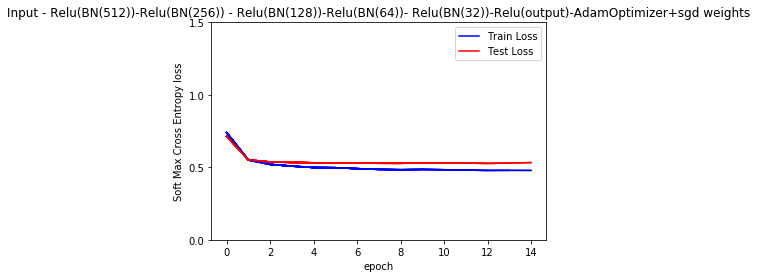

In [52]:
# Since we are using Relu activations in hidden layers we will be using weights that are initalized as weights_relu
ybatch = multilayer_perceptron_batch(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
# cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ybatch, labels = y_))

# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-AdamOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))


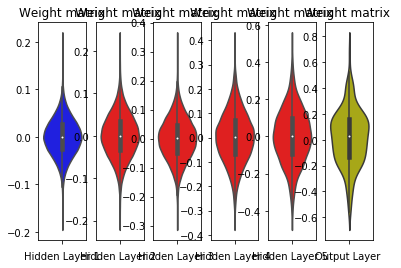

In [53]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

**__** Model 5 + GradientDescentOptimizer +sgd weights  __

Epoch: 0001 train cost=2.327599234 test cost=2.316790706
Epoch: 0002 train cost=1.989982423 test cost=1.969240628
Epoch: 0003 train cost=1.739928756 test cost=1.713634391
Epoch: 0004 train cost=1.544301625 test cost=1.510949760
Epoch: 0005 train cost=1.405087884 test cost=1.365819290
Epoch: 0006 train cost=1.301442342 test cost=1.261115432
Epoch: 0007 train cost=1.220748519 test cost=1.181404916
Epoch: 0008 train cost=1.159522015 test cost=1.117951129
Epoch: 0009 train cost=1.104363267 test cost=1.065526764
Epoch: 0010 train cost=1.060402561 test cost=1.021115789
Epoch: 0011 train cost=1.024166561 test cost=0.982820864
Epoch: 0012 train cost=0.988147412 test cost=0.949532944
Epoch: 0013 train cost=0.959143655 test cost=0.920351206
Epoch: 0014 train cost=0.932468203 test cost=0.894688347
Epoch: 0015 train cost=0.907928183 test cost=0.871852500
Accuracy: 0.7354


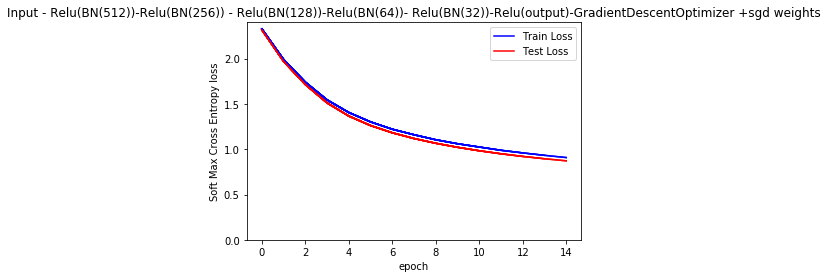

In [54]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 2.5, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-GradientDescentOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(0, 2.5, step=0.5), "Input - Relu(BN(512))-Relu(BN(256)) - Relu(BN(128))-Relu(BN(64))- Relu(BN(32))-Relu(output)-GradientDescentOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

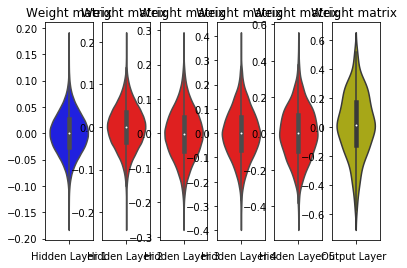

In [55]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

***Model 6: Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)***

In [0]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    layer_1_drop = tf.nn.dropout(layer_1, rate)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_2_drop = tf.nn.dropout(layer_2, rate)
    print( 'layer_2:', layer_2.get_shape(), 'W[h3]:', weights['h3'].get_shape(), 'b[h3]:', biases['b3'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_3 = tf.add(tf.matmul(layer_2_drop, weights['h3']), biases['b3']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_3 = tf.nn.relu(layer_3)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_3_drop = tf.nn.dropout(layer_3, rate)
    print( 'layer_3:', layer_3.get_shape(), 'W[h4]:', weights['h4'].get_shape(), 'b[h4]:', biases['b4'].get_shape())        
    
    
    # Hidden layer with ReLu activation
    layer_4 = tf.add(tf.matmul(layer_3_drop, weights['h4']), biases['b4']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_4 = tf.nn.relu(layer_4)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_4_drop = tf.nn.dropout(layer_4, rate)
    print( 'layer_4:', layer_4.get_shape(), 'W[h5]:', weights['h5'].get_shape(), 'b[h5]:', biases['b5'].get_shape())        
    
    
    # Hidden layer with ReLu activation
    layer_5 = tf.add(tf.matmul(layer_4_drop, weights['h5']), biases['b5']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_5 = tf.nn.relu(layer_5)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    # layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    
    layer_5_drop = tf.nn.dropout(layer_5, rate)
    print( 'layer_5:', layer_5.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b6:', biases['out'].get_shape())        
    

    # Output layer with Relu activation
    out_layer = tf.matmul(layer_5_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

Model 6 + AdamOptimizer+relu weights

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.824440532 test cost=2.324937510
Epoch: 0002 train cost=2.280541324 test cost=2.259893147
Epoch: 0003 train cost=2.045353953 test cost=1.918313573
Epoch: 0004 train cost=1.883403773 test cost=1.779957875
Epoch: 0005 train cost=1.746691633 test cost=1.649684160
Epoch: 0006 train cost=1.574269689 test cost=1.411980827
Epoch: 0007 train cost=1.305478365 test cost=1.122140323
Epoch: 0008 train cost=1.161402311 test cost=0.982084992
Epoch: 0009 train cost=0.993166657 test cost=0.778650566
Epoch: 0010 train cost=0.904045399 test cost=0.726418075
Epoch: 0011 train cost=0.849414190 test cost=0.669454407
Epoch: 0012 train cost=0.804126426 test cost=0.629340300
Epoch: 0013 tra

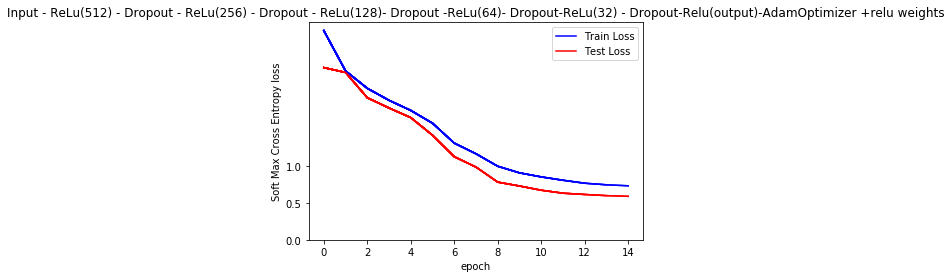

In [57]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-AdamOptimizer +relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-AdamOptimizer +relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

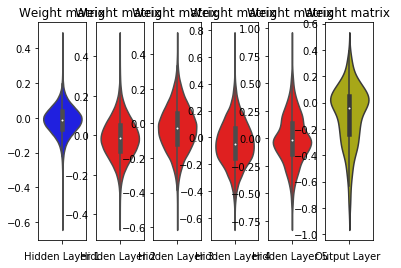

In [58]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

![alt text](https://)Model6+ GradientDescentOptimizer+relu weights

Epoch: 0001 train cost=4.762555458 test cost=2.432555577
Epoch: 0002 train cost=2.435582659 test cost=2.302632703
Epoch: 0003 train cost=2.362351668 test cost=2.302585602
Epoch: 0004 train cost=2.338854576 test cost=2.302585602
Epoch: 0005 train cost=2.326329727 test cost=2.302585602
Epoch: 0006 train cost=2.320642913 test cost=2.302585602
Epoch: 0007 train cost=2.318291131 test cost=2.302585602
Epoch: 0008 train cost=2.314844031 test cost=2.302585602
Epoch: 0009 train cost=2.312784167 test cost=2.302585602
Epoch: 0010 train cost=2.311826496 test cost=2.302585602
Epoch: 0011 train cost=2.309634761 test cost=2.302585602
Epoch: 0012 train cost=2.309035350 test cost=2.302585602
Epoch: 0013 train cost=2.310018392 test cost=2.302585602
Epoch: 0014 train cost=2.308797758 test cost=2.302585602
Epoch: 0015 train cost=2.308332618 test cost=2.302585602
Accuracy: 0.098


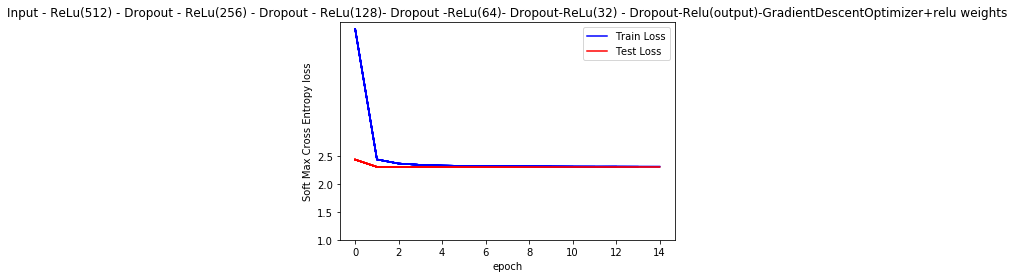

In [59]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-GradientDescentOptimizer+relu weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

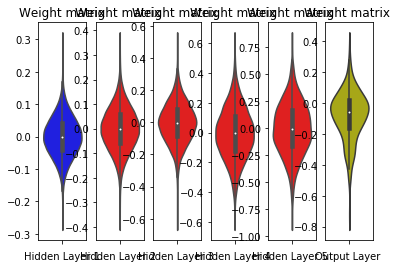

In [60]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model 6 + AdamOptimizer+sgd weights

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 256) b[h2]: (256,)
layer_2: (?, 256) W[h3]: (256, 128) b[h3]: (128,)
layer_3: (?, 128) W[h4]: (128, 64) b[h4]: (64,)
layer_4: (?, 64) W[h5]: (64, 32) b[h5]: (32,)
layer_5: (?, 32) W[out]: (32, 10) b6: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.176636768 test cost=2.043907319
Epoch: 0002 train cost=1.248464741 test cost=0.964490289
Epoch: 0003 train cost=0.742925971 test cost=0.466263262
Epoch: 0004 train cost=0.577302798 test cost=0.332870146
Epoch: 0005 train cost=0.479783674 test cost=0.273803937
Epoch: 0006 train cost=0.436242277 test cost=0.240170468
Epoch: 0007 train cost=0.387684107 test cost=0.220329923
Epoch: 0008 train cost=0.353317741 test cost=0.207425611
Epoch: 0009 train cost=0.336202192 test cost=0.193491822
Epoch: 0010 train cost=0.309740829 test cost=0.188160119
Epoch: 0011 train cost=0.290847433 test cost=0.177696577
Epoch: 0012 train cost=0.280274444 test cost=0.169725945
Epoch: 0013 tra

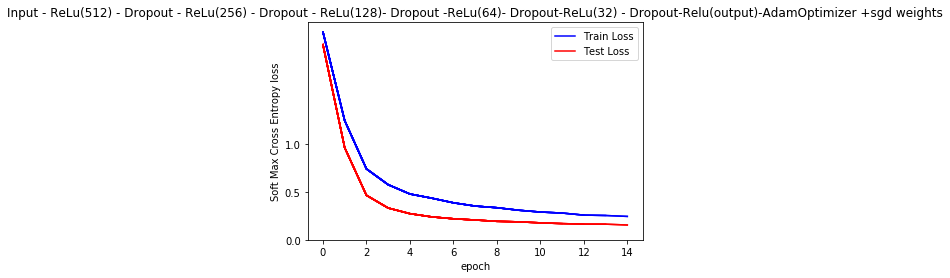

In [61]:
# https://stackoverflow.com/questions/55235230/tensorflow-please-use-rate-instead-of-keep-prob-rate-should-be-set-to-rat
rate = 1 - keep_prob

# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-AdamOptimizer +sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(0, 1.5, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-AdamOptimizer +sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

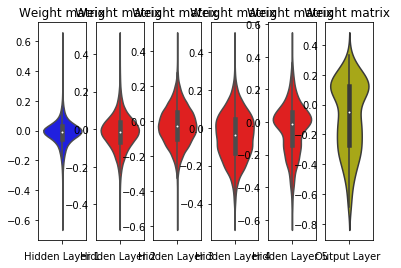

In [62]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

Model6+ GradientDescentOptimizer+sgd weights

Epoch: 0001 train cost=2.758333978 test cost=2.387984012
Epoch: 0002 train cost=2.442304459 test cost=2.322419068
Epoch: 0003 train cost=2.385471561 test cost=2.309889281
Epoch: 0004 train cost=2.361394054 test cost=2.304719867
Epoch: 0005 train cost=2.345666236 test cost=2.302640668
Epoch: 0006 train cost=2.340021173 test cost=2.302378530
Epoch: 0007 train cost=2.333769243 test cost=2.302585876
Epoch: 0008 train cost=2.329562681 test cost=2.302585602
Epoch: 0009 train cost=2.325918756 test cost=2.302585602
Epoch: 0010 train cost=2.324005344 test cost=2.302585602
Epoch: 0011 train cost=2.321902805 test cost=2.302585602
Epoch: 0012 train cost=2.320259578 test cost=2.302585602
Epoch: 0013 train cost=2.317792545 test cost=2.302585602
Epoch: 0014 train cost=2.316306800 test cost=2.302585602
Epoch: 0015 train cost=2.316653959 test cost=2.302585602
Accuracy: 0.098


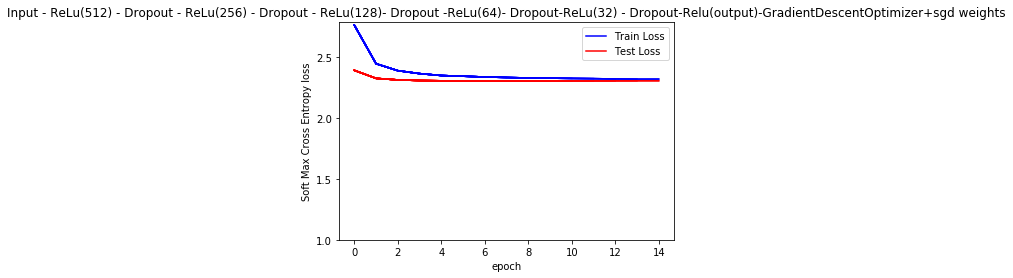

In [63]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            # _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys, rate: 0.5})
            train_avg_cost += c / total_batch
            # c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  rate: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 3, step=0.5), "Input - ReLu(512) - Dropout - ReLu(256) - Dropout - ReLu(128)- Dropout -ReLu(64)- Dropout-ReLu(32) - Dropout-Relu(output)-GradientDescentOptimizer+sgd weights")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, rate: 1.0 }))

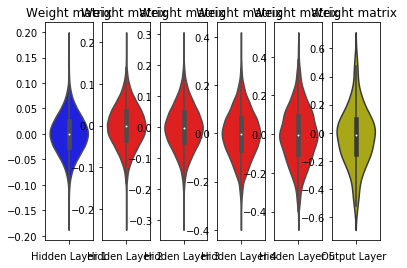

In [64]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
h3_w = w['h3'].flatten().reshape(-1,1)
h4_w = w['h4'].flatten().reshape(-1,1)
h5_w = w['h5'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 6, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 6, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 6, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 6, 4)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('Hidden Layer 4 ')

plt.subplot(1, 6, 5)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('Hidden Layer 5 ')

plt.subplot(1, 6, 6)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

In [1]:
# http://zetcode.com/python/prettytable/ 
 
from prettytable import PrettyTable 
 
x = PrettyTable() 
 
x.field_names = ["Architecture", "Model Name", "Accuracy(%)", "Train Cost", "Test Cost"] 

x.add_row(["Architecture 1: 784-501-101-10", "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-SGD Weight", 98.01,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer-SGD Weight", 11.35, 2.30,	2.30])
x.add_row(["Architecture 1: 784-501-101-10", "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-Relu Weight", 97.93,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer-Relu Weight", 11.35,	2.29,	2.29])
x.add_row(["Architecture 1: 784-501-101-10", "input(784)-ReLu(501)-ReLu(101)-sigmoid(output 10)-AdamOptimizer-SGD Weight", 97.97,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "input(784)-ReLu(501)-ReLu(101)-sigmoid(output 10)-AdamOptimizer-GradientDescentOptimizer-SGD Weight", 78.54,	1.85,	1.84])
x.add_row(["Architecture 1: 784-501-101-10", "input(784)-ReLu(501)-ReLu(101)-sigmoid(output 10)-AdamOptimizer-AdamOptimizer-Relu Weight", 98.07,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "input(784)-ReLu(501)-ReLu(101)-sigmoid(output 10)-AdamOptimizer-GradientDescentOptimizer-Relu Weight", 66.06,	1.87,	1.86])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-SGD Weight", 97.72,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output))-GradientDescentOptimizer-SGD Weight", 80.23,	2.01,	2.00])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-AdamOptimizer-Relu Weight", 98.15,	1.47,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Sigmoid(BN(501))-Sigmoid(BN(101))-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 63.25,	2.12,	2.12])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer-SGD Weight", 97.43,	1.49,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer-SGD Weight", 65.66,	2.14,	2.01])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-AdamOptimizer-Relu Weight", 97.36,	1.49,	1.48])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 54.79,	2.18,	2.03])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer-SGD Weight", 79.81,	0.70,	0.75]) 
x.add_row(["Architecture 1: 784-501-101-10", "Input-Relu(BN(501))-Relu(BN(101))-Relu(output)-GradientDescentOptimizer-SGD Weight", 81.86, 0.65,	0.61])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Relu(BN(501))-Relu(BN(101))-Relu(output)-AdamOptimizer-Relu Weight", 98.19,	0.01,	0.07])
x.add_row(["Architecture 1: 784-501-101-10", "Input-Relu(BN(501))-Relu(BN(101))-Relu(output)-GradientDescentOptimizer-Relu Weight", 89.61,	0.46,	0.42])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer-SGD Weight", 97.94,	0.08,	0.07]) 
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer-SGD Weight", 29.55,	2.13,	2.00])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-AdamOptimizer-Relu Weight", 98.02,	0.08,	0.07])
x.add_row(["Architecture 1: 784-501-101-10", "Input-ReLu(501)-Dropout-ReLu(101)-Dropout-Relu(output)-GradientDescentOptimizer-Relu Weight", 9.8,	2.30,	2.30])
print(x) 

+--------------------------------+------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
|          Architecture          |                                              Model Name                                              | Accuracy(%) | Train Cost | Test Cost |
+--------------------------------+------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
| Architecture 1: 784-501-101-10 |               input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-SGD Weight               |    98.01    |    1.47    |    1.48   |
| Architecture 1: 784-501-101-10 |         input-sigmoid(501)-sigmoid(101)-sigmoid(output)-GradientDescentOptimizer-SGD Weight          |    11.35    |    2.3     |    2.3    |
| Architecture 1: 784-501-101-10 |              input-sigmoid(501)-sigmoid(101)-sigmoid(output)-AdamOptimizer-Relu 

In [2]:
# http://zetcode.com/python/prettytable/ 
 
from prettytable import PrettyTable 
 
x = PrettyTable() 
 
x.field_names = ["Architecture", "Model Name", "Accuracy(%)", "Train Cost", "Test Cost"] 

x.add_row(["Architecture 2: 784-256-128-64-10", "input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-AdamOptimizer-SGD Weight", 97.44,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-GradientDescentOptimizer-SGD Weight", 9.8, 2.32,	2.33])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-AdamOptimizer-Relu Weight", 97.76,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-GradientDescentOptimizer-Relu Weig ht", 9.8,	2.31,	2.31])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-ReLu(256)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer-SGD Weight", 97.63,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-ReLu(256)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer-GradientDescentOptimizer-SGD Weight", 75.29,	1.92,	1.91])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-ReLu(256)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer-AdamOptimizer-Relu Weight", 97.95,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "input-ReLu(256)-ReLu(128)-ReLu(64)-sigmoid(output)-AdamOptimizer-GradientDescentOptimizer-Relu Weight", 77.88,	1.77,	1.76])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-AdamOptimizer-SGD Weight", 98.02,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output))-GradientDescentOptimizer-SGD Weight", 29.44, 2.12,	2.12])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-AdamOptimizer-Relu Weight", 98.01,	1.47,	1.48])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 9.69,	2.20,	2.19])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-AdamOptimizer-SGD Weight", 96.81,	1.50,	1.49])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-GradientDescentOptimizer-SGD Weight", 19.14,	2.29,	2.24])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-AdamOptimizer-Relu Weight", 96.45,	1.51,	1.49])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 33.93,	2.31,	2.26])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(output)-AdamOptimizer-SGD Weight", 89.2,	0.48,	0.52]) 
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(output)-GradientDescentOptimizer-SGD Weight", 88.51, 0.50,	0.47])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(output)-AdamOptimizer-Relu Weight", 98.13,	0.01,	0.08])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(output)-GradientDescentOptimizer-Relu Weight", 79.84,	0.76,	0.71])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-Relu(output)-AdamOptimizer-SGD Weight", 97.58,	0.14,	0.1]) 
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-Relu(output)-GradientDescentOptimizer-SGD Weight", 9.8,	2.31,	2.30])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-Relu(output)-AdamOptimizer-Relu Weight", 97.39,	0.16,	0.1])
x.add_row(["Architecture 2: 784-256-128-64-10", "Input-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-Relu(output)-GradientDescentOptimizer-Relu Weight", 40.48,	2.28,	2.21])
print(x) 

+-----------------------------------+-----------------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
|            Architecture           |                                                    Model Name                                                   | Accuracy(%) | Train Cost | Test Cost |
+-----------------------------------+-----------------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
| Architecture 2: 784-256-128-64-10 |               input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-AdamOptimizer-SGD Weight              |    97.44    |    1.47    |    1.48   |
| Architecture 2: 784-256-128-64-10 |         input-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(output)-GradientDescentOptimizer-SGD Weight         |     9.8     |    2.32    |    2.33   |
| Architecture 2: 784-256-128-64-10 |        

In [5]:
# http://zetcode.com/python/prettytable/ 
 
from prettytable import PrettyTable 
 
x = PrettyTable() 
 
x.field_names = ["Architecture", "Model Name", "Accuracy(%)", "Train Cost", "Test Cost"] 

x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-sigmoid(512)-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(32)-sigmoid(output)-AdamOptimizer-SGD Weight", 72.25,	1.56,	1.56])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-sigmoid(512)-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(32)-sigmoid(output)-GradientDescentOptimizer-SGD Weight", 10.09, 2.32,	2.32])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-sigmoid(512)-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(32)-sigmoid(output)-AdamOptimizer-Relu Weight", 97.55,	1.47,	1.48])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-sigmoid(512)-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(32)-sigmoid(output)-GradientDescentOptimizer-Relu Weig ht", 11.35,	2.31,	2.31])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-ReLu(512)-ReLu(256)-ReLu(128)-ReLu(64)-ReLu(32)-sigmoid(output)-AdamOptimizer-SGD Weight", 96.78,	1.47,	1.48])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-ReLu(512)-ReLu(256)-ReLu(128)-ReLu(64)-ReLu(32)-sigmoid(output)-AdamOptimizer-GradientDescentOptimizer-SGD Weight", 63.88,	1.95,	1.95])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-ReLu(512)-ReLu(256)-ReLu(128)-ReLu(64)-ReLu(32)-sigmoid(output)-AdamOptimizer-AdamOptimizer-Relu Weight", 97.94,	1.47,	1.48])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "input-ReLu(512)-ReLu(256)-ReLu(128)-ReLu(64)-ReLu(32)-sigmoid(output)-AdamOptimizer-GradientDescentOptimizer-Relu Weight", 83.84,	1.65,	1.64])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Sigmoid(BN(512))-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-SGD Weight", 97.48,	1.47,	1.48])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Sigmoid(BN(512))-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(BN(32))-Sigmoid(output))-GradientDescentOptimizer-SGD Weight", 43.8,	2.18,	2.17])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Sigmoid(BN(512))-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(BN(32))-Sigmoid(output)-AdamOptimizer-Relu Weight", 97.76,	1.47,	1.48])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Sigmoid(BN(512))-Sigmoid(BN(256))-Sigmoid(BN(128))-Sigmoid(BN(64))-Sigmoid(BN(32))-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 9.74,	2.20,	2.20])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Sigmoid(output)-AdamOptimizer-SGD Weight", 40.26,	1.83,	1.81])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Sigmoid(output)-GradientDescentOptimizer-SGD Weight", 10.56,	2.38,	2.32])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Sigmoid(output)-AdamOptimizer-Relu Weight", 40.34,	1.73,	1.72])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-Dropout-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Sigmoid(output)-GradientDescentOptimizer-Relu Weight", 7.85,	2.34,	2.33])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Relu(BN(512))-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(BN(32))-Relu(output)-AdamOptimizer-SGD Weight", 89.75,	0.48,	0.53]) 
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Relu(BN(512))-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(BN(32))-Relu(output)-GradientDescentOptimizer-SGD Weight", 73.54, 0.91,	0.87])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Relu(BN(512))-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(BN(32))-Relu(output)-AdamOptimizer-Relu Weight", 98,	0.01,	0.08])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-Relu(BN(512))-Relu(BN(256))-Relu(BN(128))-Relu(BN(64))-Relu(BN(32))-Relu(output)-GradientDescentOptimizer-Relu Weight", 82.98,	0.68,	0.64])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Relu(output)-AdamOptimizer-SGD Weight", 96.74,	0.24,	0.15 ]) 
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Relu(output)-GradientDescentOptimizer-SGD Weight", 9.8,	2.32,	2.30])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Relu(output)-AdamOptimizer-Relu Weight", 77.78,	0.73,	0.59])
x.add_row(["Architecture 3: 784-512-256-128-64-32-10", "Input-ReLu(512)-Dropout-ReLu(256)-ReLu(128)-Dropout-ReLu(64)-Dropout-ReLu(32)-Dropout-Relu(output)-GradientDescentOptimizer-Relu Weight", 9.8,	2.31,	2.30])
print(x) 

+------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
|               Architecture               |                                                                     Model Name                                                                     | Accuracy(%) | Train Cost | Test Cost |
+------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------+-----------+
| Architecture 3: 784-512-256-128-64-32-10 |                   input-sigmoid(512)-sigmoid(256)-sigmoid(128)-sigmoid(64)-sigmoid(32)-sigmoid(output)-AdamOptimizer-SGD Weight                    |    72.25    |    1.56    |    1.56   |
| Architecture 3: 784-512-256-128-64-32-10 |              input-sigm